## Data Engineering

### Import Libraries

In [551]:
# import all libraries required to load, transform, analyze and plot data (for entire notebook)
import numpy as np
import pandas as pd
from pandas.plotting import table
import matplotlib.pyplot as plt
import matplotlib.colors as pltcol
import matplotlib.ticker as ticker
import seaborn as sns
%matplotlib inline
import math

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.tools.eval_measures as ev
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score
from stepwise_regression import step_reg
import scipy.stats as stats
from scipy.special import boxcox1p,  inv_boxcox
from haversine import haversine

In [552]:
# set display option to remove scientific notation and restrictions on df rows/columns display
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', None)
pd.set_option("max_rows", None)

### Load Ticket Sales Data

In [646]:
# load season ticket sales df
sales = pd.read_csv('Braves_2022_Season_Data.csv')
sales.head()

,GAME_DATE,DAY,START_TIME_ET,GAME,TYPE,LIST_DATE,LIST_DAYS_REMAIN,ORDER_NO,SALE_DATE,SALE_DAYS_REMAIN,QTY_AVAIL,QTY_SOLD,SALE_UNIT_PRICE,SALE_EXT_AMT,STUBHUB_FEES,NET_PAYOUT,UNIT_COST,EXT_COST,MARGIN,MARGIN_PCT,M2_MAY,M3_JUN,M4_JUL,M5_AUG,M6_SEP,M7_SCHOOL_OUT,DOW,D1_TUE,D2_WED,D3_THUR,D4_FRI,D5_SAT,D6_SUN,S1_OPENER,S2_MOTHERS_DAY,S3_INDEPENDENCE_DAY,FULL_DATE,DAY_NIGHT,START_TIME,T1_DAY_1PM,T1_DAY_4PM,BRAVES_CLASS,HOME_TEAM,AWAY_TEAM,O01_NYM,O02_PHL,O03_MIA,O04_STL,O05_MIL,O06_CHC,O07_PIT,O08_CIN,O09_LAD,O10_SDP,O11_SFG,O12_ARI,O13_COL,O14_HOU,O15_LAA,O16_OAK,O17_BOS,OC1_DIVISION,OC2_AL_INTER,OUTCOME,RUNS,RA,INNINGS,POST_RECORD,BRAVES_RANK,R1_BRAVES_GB,WIN,LOSS,SAVE,TIME,ATTENDANCE,CLI,STREAK,E1_BOBBLEHEAD,E2_WS_REPLICA_RING,OPP_RANK,OPP_2022_ATTEND_AVG,OPP_MSA_POP,OPP_POP_PER_ATTEND,OPP_FORBES_VAL
0,4/7/22,Thu,8:08 PM,Reds at Braves,PARKING,3/20/22,18.00,"271,602,197.00",3/25/22,13.00,1,1,69.00,69.00,10.35,58.65,18.00,18.00,40.65,226%,0,0,0,0,0,0,5,0,0,1,0,0,0,1,0,0,"Thursday, Apr 7",N,8:08 PM,0,0,1_Diamond,ATL,CIN,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,L,3,6,0,0-1,1.00,0.00,Mahle,Fried,Santillan,3:01,40545,0.96,0.00,0,0,4.00,17447,2259935,130,1.19
1,4/7/22,Thu,8:08 PM,Reds at Braves,SEATS,3/20/22,18.00,"271,881,539.00",4/4/22,3.00,2,2,65.00,130.00,19.50,110.50,18.00,36.00,74.50,207%,0,0,0,0,0,0,5,0,0,1,0,0,0,1,0,0,"Thursday, Apr 7",N,8:08 PM,0,0,1_Diamond,ATL,CIN,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,L,3,6,0,0-1,1.00,0.00,Mahle,Fried,Santillan,3:01,40545,0.96,0.00,0,0,4.00,17447,2259935,130,1.19
2,4/7/22,Thu,8:08 PM,Reds at Braves,SEATS,3/20/22,18.00,"271,942,973.00",4/6/22,1.00,2,2,47.00,94.00,14.10,79.90,18.00,36.00,43.90,122%,0,0,0,0,0,0,5,0,0,1,0,0,0,1,0,0,"Thursday, Apr 7",N,8:08 PM,0,0,1_Diamond,ATL,CIN,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,L,3,6,0,0-1,1.00,0.00,Mahle,Fried,Santillan,3:01,40545,0.96,0.00,0,0,4.00,17447,2259935,130,1.19
3,4/8/22,Fri,7:20 PM,Reds at Braves,PARKING,3/20/22,19.00,"271,504,107.00",3/21/22,18.00,1,1,79.00,79.00,11.85,67.15,18.00,18.00,49.15,273%,0,0,0,0,0,0,6,0,0,0,1,0,0,0,0,0,"Friday, Apr 8",N,7:20 PM,0,0,2_Marquee,ATL,CIN,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,W,7,6,0,44927,1.00,0.00,Morton,Sanmartin,0,3:07,40234,0.92,0.00,0,0,4.00,17447,2259935,130,1.19
4,4/8/22,Fri,7:20 PM,Reds at Braves,SEATS,3/20/22,19.00,"271,509,271.00",3/21/22,18.00,4,4,44.00,176.00,26.40,149.60,18.00,72.00,77.60,108%,0,0,0,0,0,0,6,0,0,0,1,0,0,0,0,0,"Friday, Apr 8",N,7:20 PM,0,0,2_Marquee,ATL,CIN,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,W,7,6,0,44927,1.00,0.00,Morton,Sanmartin,0,3:07,40234,0.92,0.00,0,0,4.00,17447,2259935,130,1.19


In [647]:
# data type conversions
sales['GAME_DATE'] = pd.to_datetime(sales['GAME_DATE']) # conversion helps use column for month and year
sales['LIST_DATE'] = pd.to_datetime(sales['LIST_DATE']) 
sales['SALE_DATE'] = pd.to_datetime(sales['SALE_DATE']) 
sales['LIST_DAYS_REMAIN'] = sales['LIST_DAYS_REMAIN'].fillna(0).astype(int) # convert to proper data type
sales['SALE_DAYS_REMAIN'] = sales['SALE_DAYS_REMAIN'].fillna(0).astype(int)
sales['OPP_RANK'] = sales['OPP_RANK'].fillna(0).astype(int)

In [555]:
# review data types
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175 entries, 0 to 174
Data columns (total 84 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   GAME_DATE             175 non-null    datetime64[ns]
 1   DAY                   175 non-null    object        
 2   START_TIME_ET         175 non-null    object        
 3   GAME                  175 non-null    object        
 4   TYPE                  175 non-null    object        
 5   LIST_DATE             164 non-null    datetime64[ns]
 6   LIST_DAYS_REMAIN      175 non-null    int64         
 7   ORDER_NO              159 non-null    float64       
 8   SALE_DATE             159 non-null    datetime64[ns]
 9   SALE_DAYS_REMAIN      175 non-null    int64         
 10  QTY_AVAIL             175 non-null    int64         
 11  QTY_SOLD              175 non-null    int64         
 12  SALE_UNIT_PRICE       173 non-null    float64       
 13  SALE_EXT_AMT        

In [556]:
# quick distribution check
sales.describe()

,LIST_DAYS_REMAIN,ORDER_NO,SALE_DAYS_REMAIN,QTY_AVAIL,QTY_SOLD,SALE_UNIT_PRICE,SALE_EXT_AMT,STUBHUB_FEES,NET_PAYOUT,UNIT_COST,EXT_COST,MARGIN,M2_MAY,M3_JUN,M4_JUL,M5_AUG,M6_SEP,M7_SCHOOL_OUT,DOW,D1_TUE,D2_WED,D3_THUR,D4_FRI,D5_SAT,D6_SUN,S1_OPENER,S2_MOTHERS_DAY,S3_INDEPENDENCE_DAY,T1_DAY_1PM,T1_DAY_4PM,O01_NYM,O02_PHL,O03_MIA,O04_STL,O05_MIL,O06_CHC,O07_PIT,O08_CIN,O09_LAD,O10_SDP,O11_SFG,O12_ARI,O13_COL,O14_HOU,O15_LAA,O16_OAK,O17_BOS,OC1_DIVISION,OC2_AL_INTER,RUNS,RA,INNINGS,BRAVES_RANK,R1_BRAVES_GB,ATTENDANCE,CLI,STREAK,E1_BOBBLEHEAD,E2_WS_REPLICA_RING,OPP_RANK,OPP_2022_ATTEND_AVG,OPP_MSA_POP,OPP_POP_PER_ATTEND,OPP_FORBES_VAL
count,175.00,159.00,175.00,175.00,175.00,173.00,173.00,173.00,173.00,175.00,175.00,175.00,175.00,175.00,175.00,175.00,175.00,175.00,175.00,175.00,175.00,175.00,175.00,175.00,175.00,175.00,175.00,175.00,175.00,175.00,175.00,175.00,175.00,175.00,175.00,175.00,175.00,175.00,175.00,175.00,175.00,175.00,175.00,175.00,175.00,175.00,175.00,175.00,175.00,175.00,175.00,175.00,159.00,159.00,175.00,175.00,158.00,175.00,175.00,175.00,175.00,175.00,175.00,175.00
mean,16.35,"409,161,600.43",6.14,2.25,1.85,39.22,83.55,9.83,73.72,18.00,40.53,32.35,0.18,0.14,0.21,0.15,0.17,0.42,4.06,0.17,0.13,0.10,0.18,0.15,0.18,0.02,0.01,0.01,0.18,0.05,0.14,0.11,0.11,0.06,0.03,0.04,0.05,0.05,0.04,0.03,0.02,0.04,0.05,0.03,0.05,0.03,0.02,0.46,0.14,4.94,3.34,0.82,2.10,3.80,"38,778.54",1.09,1.10,0.22,0.03,2.87,"27,352.20","7,718,459.60",300.73,2.10
std,9.87,"113,550,596.35",7.38,1.35,1.30,30.41,103.15,12.08,91.51,0.00,24.37,85.25,0.38,0.35,0.41,0.36,0.38,0.49,2.08,0.38,0.34,0.30,0.38,0.36,0.39,0.13,0.08,0.11,0.38,0.22,0.34,0.32,0.31,0.23,0.17,0.20,0.21,0.21,0.20,0.18,0.15,0.20,0.21,0.18,0.21,0.18,0.15,0.50,0.34,3.14,2.61,2.90,0.56,2.51,"3,875.52",0.52,2.60,0.41,0.17,1.64,"9,678.11","5,587,989.03",183.44,0.87
min,0.00,"271,501,789.00",0.00,1.00,0.00,0.00,0.00,0.00,0.00,18.00,18.00,-90.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,-0.50,"29,339.00",0.70,-3.00,0.00,0.00,0.00,"9,973.00","1,566,487.00",52.00,0.99
25%,10.00,"273,472,390.00",0.50,1.00,1.00,19.86,26.00,2.80,23.40,18.00,18.00,-3.50,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00,2.00,0.00,2.00,2.00,"36,307.00",0.81,-1.00,0.00,0.00,1.00,"19,817.00","3,286,069.00",151.00,1.32
50%,15.00,"501,920,337.00",3.00,2.00,1.00,32.95,40.13,5.38,35.70,18.00,36.00,11.71,0.00,0.00,0.00,0.00,0.00,0.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.00,3.00,0.00,2.00,3.00,"40,224.00",0.96,1.00,0.00,0.00,3.00,"30,155.00","6,228,601.00",254.00,2.00
75%,22.00,"503,744,789.00",10.00,4.00,3.00,49.00,94.95,12.99,80.71,18.00,72.00,43.75,0.00,0.00,0.00,0.00,0.00,1.00,6.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,6.00,5.00,0.00,2.00,6.00,"42,161.00",1.21,2.00,0.00,0.00,4.00,"33,308.00","9,509,934.00",464.00,2.65
max,42.00,"506,418,004.00",32.00,5.00,4.00,159.00,536.00,80.40,455.60,18.00,90.00,383.60,1.00,1.00,1.00,1.00,1.00,1.00,7.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,16.00,12.00,12.00,4.00,10.50,"42,925.00",4.11,10.00,1.00,1.00,5.00,"47,671.00","19,768,458.00",594.00,4.08


### Functions

#### check_normality()

In [557]:
# function checks column outliers and skew; tests normality showing a histogram
def check_normality(df, col, bins=20):
    """Plots histogram; prints 4th positive standard deviation and observation 
    counts, skew and kurtosis for column normality assessment.

    Parameters:
    df (pd.DataFrame)): Name of Pandas dataframe.
    col (string): Name of the column to check; must be in df.columns.
    bins (int): Number of bins in histogram. Default set to 20.

    Returns: No return
   """
    
    std4 = df[col].mean()+4*df[col].std()
    std4_cnt = len(df[df[col]>std4])
    print(f'{col} 4 Std Dev: {std4} | Home Counts above this size: {std4_cnt} | Skew: {df[col].skew()} | Kurtosis: {df[col].kurtosis()}')
    df[col].hist(figsize=(8,4), bins=bins)
    return

#### create_log()

In [559]:
# function generates log column for variable that is non-normal/skewed
def create_log(df, column, col_pos=0, bins=20):
    """Creates new column using log transformation. Plots histogram for original 
    and new log column; prints skew and kurtosis for column normality assessment.

    Parameters:
    df (pd.DataFrame)): Name of Pandas dataframe.
    col (string): Name of the column to create new log column; must be in df.columns.
    col_pos (int): Desired position number for new column; default set to 0
    bins (int): Number of bins in histogram. Default set to 20.

    Returns: No return
   """
    
    col_log_name = f'{column}_LOG'
    df.insert(loc=col_pos, column=col_log_name, value=np.log(df[column], where=df[column] > 0))
    df[[column, col_log_name]].hist(figsize=(12,4), bins=bins)
    plt.show()
    print(f'{col_log_name} skew: {df[col_log_name].skew()}')
    print(f'{col_log_name} kurtosis: {df[col_log_name].kurtosis()}')
    return

#### calc_sm_ols()

In [560]:
# function takes X and y dataframes and generates statsmodel OLS results
def calc_sm_ols(model_nbr, X, y):
    """Runs and returns statsmodel Ordinary Least Squares (OLS) regression model.
       Takes in X predictors and y target, generates model, predictions and 
       performance stats.
    
        Parameters:
        model_nbr (int): sequence number you've created for model iteration
        X (pd.DataFrame): train or test slice contains predictors
        y (pd.DataFrame)): train or test slice contains target

        Returns:
        model (linear_model): statsmodel fitted OLS model object
        rsq_adj (float): model adjusted r-squared
        rmse (float): model root mean squared error
        mae (float): models mean absolute error
   """
    
    model = sm.OLS(y, X).fit()
    print(model.summary())
    
    # generate model predictions and calculate errors 
    y_pred = model.predict(X)
    if y.name == 'SALE_UNIT_PRICE' :
        rmse = round(ev.rmse(y, y_pred))
        mae = round(ev.meanabs(y, y_pred))
        print(f'\nModel {model_nbr} Summary Statistics')
        print(f'Root Mean Squared Error (RMSE): {rmse}.')
        print(f'Mean Absolute Error (MAE): {mae}.')
    elif y.name == 'SALE_UNIT_PRICE_LOG' :
        rmse = round(ev.rmse(np.exp(y), np.exp(y_pred)))
        mae = round(ev.meanabs(np.exp(y), np.exp(y_pred)))
        mae_log = ev.meanabs(y, y_pred)
        print(f'\nModel {model_nbr} Summary Statistics')
        print(f'Root Mean Squared Error (RMSE): {rmse}.')
        print(f'Mean Absolute Error (MAE): {mae} | Log y: {mae_log}')
    elif y.name == 'SALE_UNIT_PRICE_SQRT' :
        rmse = round(ev.rmse(y*y, y_pred*y_pred))
        mae = round(ev.meanabs(y*y, y_pred*y_pred))
        mae_sqrt = ev.meanabs(y, y_pred)
        print(f'\nModel {model_nbr} Summary Statistics')
        print(f'Root Mean Squared Error (RMSE): {rmse}.')
        print(f'Mean Absolute Error (MAE): {mae} | SQRT y: {mae_sqrt}')        
    else :
        print(f'Cannot calculate RMSE and MAE from y variable {y}')
    rsq_adj = model.rsquared_adj                 
    return model, rsq_adj, rmse, mae

#### qqplot()

In [561]:
# function to generate QQ-plot for an OLS model
def qqplot(model_nbr, model):
    """Displays a QQ-plot for a statsmodel OLS object to inspect
       normality of model residual errors.
    
        Parameters:
        model_nbr (int): sequence number you've created for model iteration
        model (linear_model): statsmodel fitted OLS model object

        Returns: no return
   """
        
    # generate QQ-plot
    residuals = model.resid
    sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
    plt.title(f'\nModel {model_nbr} QQ-plot' )
    plt.tight_layout()
    plt.show()

#### plot_residuals()

In [562]:
# function to generate residuals for each independent variable in an OLS model
def plot_residuals(model_nbr, model):
    """Displays sequential residual plots for each predictor (X) in a statsmodel OLS object for 
       testing normality of model residuals on specific features.
    
        Parameters:
        model_nbr (int): sequence number you've created for model iteration
        model (linear_model): statsmodel fitted OLS model object

        Returns: no return
   """    
    
    # loop through variables to show residuals for each
    x_vars = model.params.keys().tolist()
    x_vars.remove('const')

    for x in x_vars:
        f = plt.figure(figsize=(15,8))
        f = sm.graphics.plot_regress_exog(model, x, fig=f)   
        f.tight_layout()
        plt.show()

# review in future iteration Checking Heteroscadasticity (Goldfeld-Quandt test)

#### kfolds()

In [563]:
# function using K-folds cross-validation to validate OLS model
def kfolds(X, y, cv=5):
    """Performs cross-validation using cv number of folds against full 
       sample X and y. Prints out CV mean absolute errors for comparison 
       to OLS model MAE. Supplemental validation to OLS train-test split.
    
        Parameters:
        X (pd.DataFrame): full sample contains model predictors
        y (pd.DataFrame)): full sample contains model target

        Returns: no return
   """
    
    model = LinearRegression()
    model.fit(X, y)
    mae = make_scorer(mean_absolute_error)
    cv_5_results = cross_val_score(model, X, y, cv=cv, scoring=mae)
    print(f'Cross-Validation MAE results: {cv_5_results} | CV MAE Mean: {cv_5_results.mean()}')

#### normalize()

In [565]:
# normalize a feature (subract mean and divide by std)
def normalize(feature):
    return (feature - feature.mean()) / feature.std()

#denormalize (add mean and multiple by std)
def denormalize(feature, log_df):
    return log_df['price_log'].std()*feature + log_df['price_log'].mean()

#### predict()

In [566]:
# function predicts y_pred using model, compares rmse / mae between training and test
def predict(model_nbr, model, X_train, X_test, y_train, y_test):
    """Generates predictions, prints comparison stats for train and test dataframes.
       Works for price and price_log targets. For price_log, calculates RMSE and MAE
       by transforming back to price.
    
        Parameters:
        model_nbr (int): sequence number you've created for model iteration
        model (linear_model): statsmodel fitted OLS model object
        X_train (pd.DataFrame): train slice contains predictors
        X_test (pd.DataFrame): test slice contains predictors
        y_train (pd.DataFrame): train slice contains target
        y_test (pd.DataFrame): test slice contains target

        Returns: 
        y_pred_train (float): train set predictions
        y_pred_test (float): test set predictions
   """   
    
    # Calculate predictions on training and test sets
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    if y_train.name == 'SALE_UNIT_PRICE':
        rmse_train = round(ev.rmse(y_train, y_pred_train))
        mae_train = round(ev.meanabs(y_train, y_pred_train))
        rmse_test = round(ev.rmse(y_test, y_pred_test))
        mae_test = round(ev.meanabs(y_test, y_pred_test))       
        
    elif y_train.name == 'SALE_UNIT_PRICE_LOG':
        rmse_train = round(ev.rmse(np.exp(y_train), np.exp(y_pred_train)))
        mae_train = round(ev.meanabs(np.exp(y_train), np.exp(y_pred_train)))
        rmse_test = round(ev.rmse(np.exp(y_test), np.exp(y_pred_test)))
        mae_test = round(ev.meanabs(np.exp(y_test), np.exp(y_pred_test)))
 
    elif y_train.name == 'SALE_UNIT_PRICE_SQRT':
        rmse_train = round(ev.rmse(y_train*y_train, y_pred_train*y_pred_train))
        mae_train = round(ev.meanabs(y_train*y_train, y_pred_train*y_pred_train))
        rmse_test = round(ev.rmse(y_train*y_train, y_pred_train*y_pred_train))
        mae_test = round(ev.meanabs(y_train*y_train, y_pred_train*y_pred_train))
    
    else :
        print(f'Cannot calculate RMSE and MAE from y variable {y_train.name}')
                     
    print(f'\nModel {model_nbr} Prediction Statistics\n--------------------------')
    print(f'Root Mean Squared Error (RMSE): Test {rmse_test} | Train {rmse_train} | \
          Difference {rmse_test-rmse_train} | % Diff {(rmse_test-rmse_train)/rmse_train}')
    print(f'Mean Absolute Error (MAE): Test {mae_test} | Train {mae_train} | \
          Difference {mae_test-mae_train} | % Diff {(mae_test-mae_train)/mae_train}')
    
    return y_pred_train, y_pred_test

### Feature Review

In [661]:
# set sell-out indicator if attendance exceeds 41,084 capacity at Truist Park for 2022 season
WKND = [1,6,7]
WEEK = [2,3,4,5]
sales['SELL_OUT'] = sales['ATTENDANCE'].apply(lambda x: 1 if x >= 41084 else 0)
sales['SELL_OUT_WKND'] = np.where((sales.SELL_OUT == 1) & (sales.DOW.isin(WKND)), 1, 0)
sales['SELL_OUT_WEEK'] = np.where((sales.SELL_OUT == 1) & (sales.DOW.isin(WEEK)), 1, 0)
sales['QTY_SINGLE'] = sales['QTY_SOLD'].apply(lambda x: 1 if x == 1 else 0)
sales['QTY_FOUR'] = sales['QTY_SOLD'].apply(lambda x: 1 if x == 4 else 0)
sales['OPP_RANK1'] = sales['OPP_RANK'].apply(lambda x: 1 if x == 1 else 0)
sales['OPP_RANK2'] = sales['OPP_RANK'].apply(lambda x: 1 if x == 2 else 0)
sales['OPP_RANK3'] = sales['OPP_RANK'].apply(lambda x: 1 if x == 3 else 0)
sales['OPP_RANK4'] = sales['OPP_RANK'].apply(lambda x: 1 if x == 4 else 0)
sales['OPP_RANK5'] = sales['OPP_RANK'].apply(lambda x: 1 if x == 5 else 0)
sales['SOLD_SAME_DAY'] = sales['SALE_DAYS_REMAIN'].apply(lambda x: 1 if x == 0 else 0)
sales['SALE_DAYS_REMAIN_ADJ'] = sales['SALE_DAYS_REMAIN'].apply(lambda x: 0.5 if x == 0 else x)
sales['SALE_DAYS_REMAIN_SQRT'] = np.sqrt(sales['SALE_DAYS_REMAIN_ADJ'])
sales['ATTENDANCE_SQRT'] = np.sqrt(sales['ATTENDANCE'])
sales['ATTENDANCE_NORM'] = normalize(sales['ATTENDANCE'])
sales['SALE_UNIT_PRICE_SQRT'] = np.sqrt(sales['SALE_UNIT_PRICE'])
sales['QTY_SINGLE_SAME_DAY'] = sales['QTY_SOLD'].apply(lambda x: 1 if x == 1 else 0)

In [663]:
# split df into seats versus parking ticket sales to drive separate models
seats = sales[(sales.TYPE == 'SEATS') & (sales.SALE_UNIT_PRICE > 0)]
parking = sales[(sales.TYPE == 'PARKING') & (sales.SALE_UNIT_PRICE > 0)]

In [664]:
# replicate rows based on quantify sold so dataset includes 1 row per ticket sold
print(f'seats: {len(seats)} records before')
seats = seats.loc[seats.index.repeat(seats.QTY_SOLD)]
print(f'seats: {len(seats)} records after')

seats: 100 records before
seats: 261 records after


SALE_UNIT_PRICE 4 Std Dev: 193.7538212509578 | Home Counts above this size: 0 | Skew: 1.2311768497529056 | Kurtosis: 0.8331935821617966


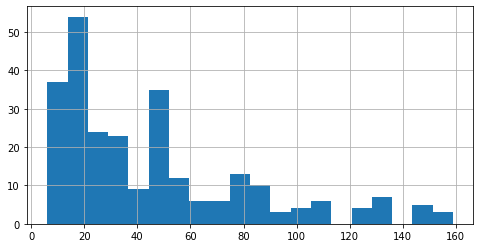

In [665]:
check_normality(seats, 'SALE_UNIT_PRICE')

SALE_UNIT_PRICE_SQRT 4 Std Dev: 16.534483125886126 | Home Counts above this size: 0 | Skew: 0.6133246885379257 | Kurtosis: -0.4854783642696927


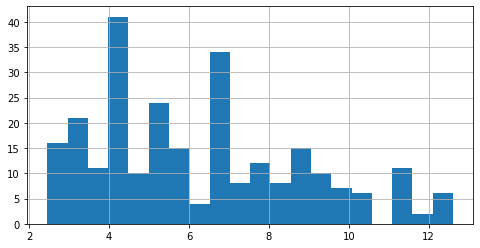

In [666]:
check_normality(seats, 'SALE_UNIT_PRICE_SQRT')

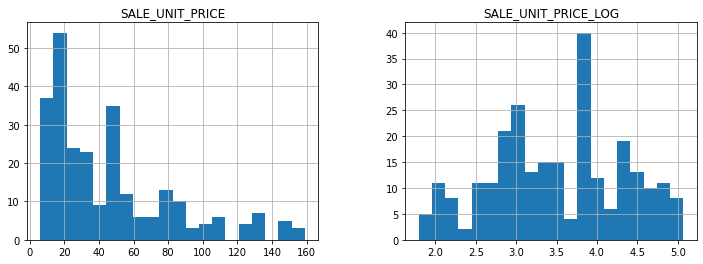

SALE_UNIT_PRICE_LOG skew: -0.04758502435281379
SALE_UNIT_PRICE_LOG kurtosis: -0.8953160649039722


In [667]:
# Creating lot_size log column given skew
create_log(seats, 'SALE_UNIT_PRICE')

ATTENDANCE 4 Std Dev: 54166.154652591606 | Home Counts above this size: 0 | Skew: -0.877331124523052 | Kurtosis: -0.41764419254345064


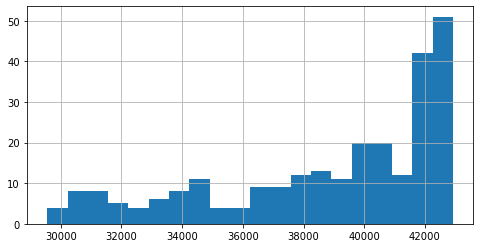

In [668]:
check_normality(seats, 'ATTENDANCE')

ATTENDANCE_NORM 4 Std Dev: 3.9704619924910394 | Home Counts above this size: 0 | Skew: -0.8773311245230498 | Kurtosis: -0.41764419254345153


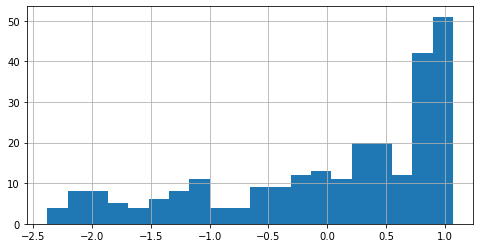

In [669]:
check_normality(seats, 'ATTENDANCE_NORM')

SALE_DAYS_REMAIN 4 Std Dev: 43.04531000261135 | Home Counts above this size: 0 | Skew: 0.910132140648396 | Kurtosis: 0.08311380136483759


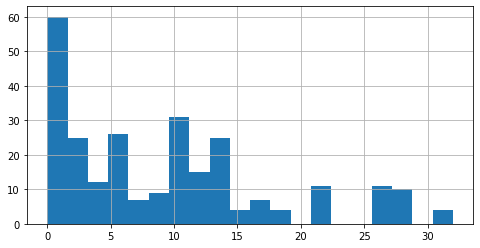

In [670]:
check_normality(seats, 'SALE_DAYS_REMAIN')

SALE_DAYS_REMAIN_SQRT 4 Std Dev: 8.446745475714533 | Home Counts above this size: 0 | Skew: 0.166142419266171 | Kurtosis: -0.9842871044665769


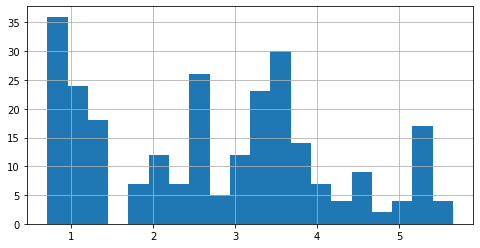

In [671]:
check_normality(seats, 'SALE_DAYS_REMAIN_SQRT')

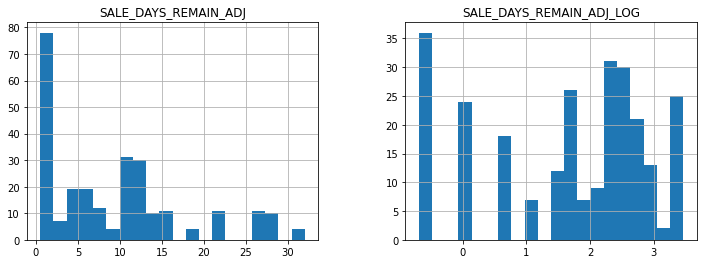

SALE_DAYS_REMAIN_ADJ_LOG skew: -0.5869973295531219
SALE_DAYS_REMAIN_ADJ_LOG kurtosis: -0.9638947858725926


In [672]:
# Creating lot_size log column given skew
create_log(seats, 'SALE_DAYS_REMAIN_ADJ')

OPP_2022_ATTEND_AVG 4 Std Dev: 66476.43828415821 | Home Counts above this size: 0 | Skew: -0.15215424959854681 | Kurtosis: -0.53996628710102


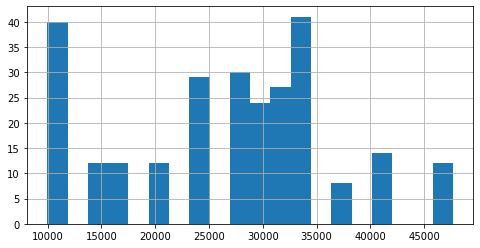

In [673]:
check_normality(seats, 'OPP_2022_ATTEND_AVG')

OPP_MSA_POP 4 Std Dev: 29684196.555600222 | Home Counts above this size: 0 | Skew: 1.236377753083034 | Kurtosis: 0.37033449836071153


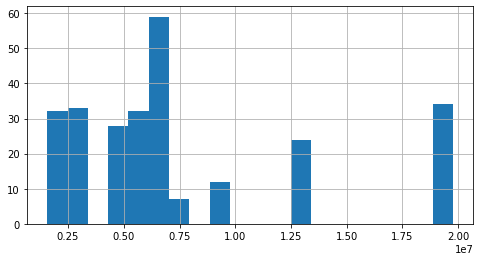

In [674]:
check_normality(seats, 'OPP_MSA_POP')

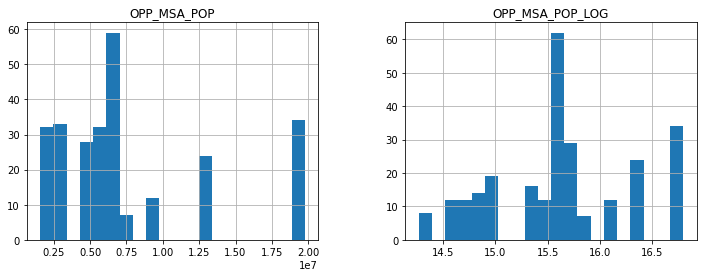

OPP_MSA_POP_LOG skew: 0.11423405438260772
OPP_MSA_POP_LOG kurtosis: -0.5972748162631283


In [675]:
create_log(seats, 'OPP_MSA_POP')

 OPP_POP_PER_ATTEND  4 Std Dev: 1032.6413049556388 | Home Counts above this size: 0 | Skew: 0.4430195358939755 | Kurtosis: -1.2123758746955633


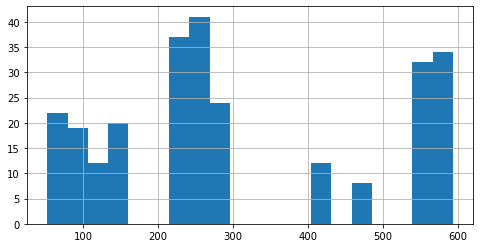

In [676]:
check_normality(seats, ' OPP_POP_PER_ATTEND ')

OPP_FORBES_VAL 4 Std Dev: 5.573956739289439 | Home Counts above this size: 0 | Skew: 0.7455749526594149 | Kurtosis: -0.11218840216607928


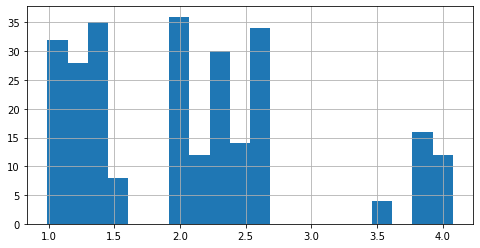

In [677]:
check_normality(seats, 'OPP_FORBES_VAL')

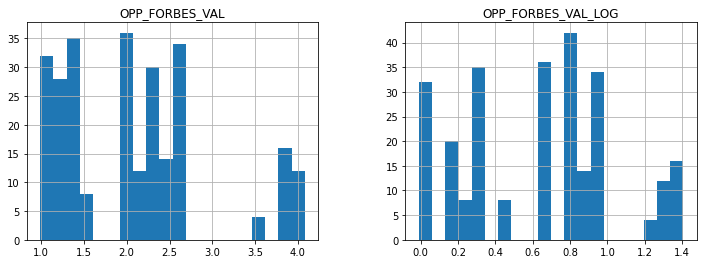

OPP_FORBES_VAL_LOG skew: 0.025379421814191887
OPP_FORBES_VAL_LOG kurtosis: -0.9619996045848951


In [678]:
create_log(seats, 'OPP_FORBES_VAL')

0.2923506144389071
ATTENDANCE_NORM_BOX 4 Std Dev: 9.454092333508209 | Home Counts above this size: 0 | Skew: -0.3079945000126337 | Kurtosis: -0.9620000282052494


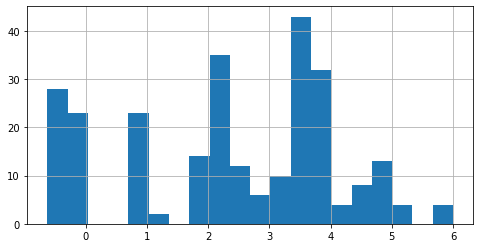

In [679]:
# apply boxcox to price to see if this feature is better than price_log
days_box = []
days_box, price_lambda = stats.boxcox(seats.SALE_DAYS_REMAIN_ADJ)
seats.insert(loc=75, column='ATTENDANCE_NORM_BOX', value=pd.Series(days_box))
print(price_lambda)
check_normality(seats, 'ATTENDANCE_NORM_BOX', bins=20)

0.2923506144389071
SALE_DAYS_REMAIN_BOX 4 Std Dev: 9.454092333508209 | Home Counts above this size: 0 | Skew: -0.3079945000126337 | Kurtosis: -0.9620000282052494


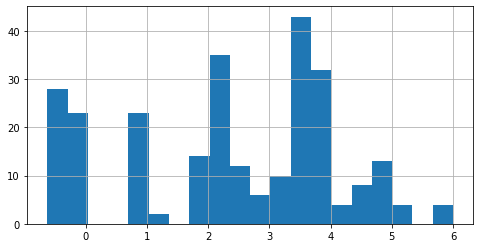

In [680]:
# apply boxcox to price to see if this feature is better than price_log
days_box = []
days_box, price_lambda = stats.boxcox(seats.SALE_DAYS_REMAIN_ADJ)
seats.insert(loc=4, column='SALE_DAYS_REMAIN_BOX', value=pd.Series(days_box))
print(price_lambda)
check_normality(seats, 'SALE_DAYS_REMAIN_BOX', bins=20)

### Correlations

In [585]:
# generate full correlation matrix
corr = seats.corr()

# correlation matrix for just price
corr['SALE_UNIT_PRICE'].sort_values(ascending=False)


SALE_UNIT_PRICE             1.00
SALE_UNIT_PRICE_SQRT        0.98
MARGIN                      0.96
NET_PAYOUT                  0.93
SALE_UNIT_PRICE_LOG         0.92
SALE_EXT_AMT                0.92
STUBHUB_FEES                0.85
SELL_OUT                    0.65
ATTENDANCE_NORM             0.63
ATTENDANCE                  0.63
ATTENDANCE_SQRT             0.62
SALE_DAYS_REMAIN_SQRT       0.49
SALE_DAYS_REMAIN            0.49
OPP_MSA_POP                 0.49
SALE_DAYS_REMAIN_ADJ        0.49
SALE_DAYS_REMAIN_ADJ_LOG    0.47
OPP_MSA_POP_LOG             0.47
O15_LAA                     0.41
CLI                         0.40
OPP_RANK1                   0.40
O09_LAD                     0.36
 OPP_POP_PER_ATTEND         0.34
DOW                         0.30
D5_SAT                      0.30
D4_FRI                      0.29
O01_NYM                     0.28
LIST_DAYS_REMAIN            0.25
ORDER_NO                    0.24
OC2_AL_INTER                0.22
OPP_FORBES_VAL              0.20
OPP_2022_A

In [586]:
# check for collinearity among potential predictors by pairs
df = (
     corr
     .stack()
     .reset_index()
     .sort_values(0, ascending=False)
)
# zip the default name columns level_0 and level_1
df['pairs'] = list(zip(df.level_0, df.level_1))
# set index to pairs
df.set_index(['pairs'], inplace=True)
# now drop level columns
df.drop(columns=['level_1', 'level_0'], inplace=True)
# rename correlation column rather than 0
df.columns = ['correlation']
# drop duplicates and keep only pair correlations above 0.65
df.drop_duplicates(inplace=True)
df[abs(df.correlation) > .65]

,correlation
pairs,
"(EXT_COST, QTY_AVAIL)",1.00
"(OPP_FORBES_VAL_LOG, OPP_FORBES_VAL_LOG)",1.00
"(ATTENDANCE, ATTENDANCE_NORM)",1.00
"(SALE_DAYS_REMAIN, SALE_DAYS_REMAIN_ADJ)",1.00
"(ATTENDANCE_NORM, ATTENDANCE_SQRT)",1.00
"(ATTENDANCE_SQRT, ATTENDANCE)",1.00
"(NET_PAYOUT, SALE_EXT_AMT)",1.00
"(MARGIN, NET_PAYOUT)",0.99
"(SALE_EXT_AMT, MARGIN)",0.99


In [587]:
# generate full correlation matrix
corr2 = seats.corr()

# correlation matrix for just price
corr2['ATTENDANCE_NORM_BOX'].sort_values(ascending=False)

ATTENDANCE_NORM_BOX         1.00
OPP_RANK5                   0.31
M4_JUL                      0.26
OPP_RANK                    0.22
O12_ARI                     0.20
INNINGS                     0.19
QTY_SOLD                    0.17
QTY_FOUR                    0.17
O04_STL                     0.16
QTY_AVAIL                   0.14
EXT_COST                    0.14
D6_SUN                      0.14
O14_HOU                     0.13
D4_FRI                      0.13
O10_SDP                     0.13
ATTENDANCE                  0.11
ATTENDANCE_NORM             0.11
OPP_2022_ATTEND_AVG         0.11
ATTENDANCE_SQRT             0.11
SALE_DAYS_REMAIN_ADJ        0.11
O15_LAA                     0.11
SALE_DAYS_REMAIN            0.11
NET_PAYOUT                  0.11
O08_CIN                     0.11
M6_SEP                      0.11
OPP_RANK2                   0.10
SALE_EXT_AMT                0.10
SELL_OUT                    0.10
SOLD_SAME_DAY               0.10
O17_BOS                     0.09
MARGIN    

## Seats Models

### Train-Test Split

In [681]:
# drop non-feature columns + drop multi-collinear columns 008_CIN, QTY_AVAIL, R1_BRAVES_GB, T1_DAY_1PM
seats.drop(columns=['MARGIN','NET_PAYOUT','SALE_EXT_AMT','STUBHUB_FEES','EXT_COST','MARGIN_PCT','WIN','LOSS','SAVE','TIME',
                    'CLI','DOW','RUNS','ORDER_NO','EXT_COST','INNINGS','RA','FULL_DATE','DAY_NIGHT','START_TIME','OUTCOME','POST_RECORD',
                    'GAME_DATE','DAY','START_TIME_ET','GAME','TYPE','LIST_DATE','SALE_DATE','BRAVES_CLASS','HOME_TEAM','AWAY_TEAM'], axis=1, inplace=True)

In [682]:
# divide dataset into X predictors and y target
X = seats.drop(['SALE_UNIT_PRICE','SALE_UNIT_PRICE_SQRT','SALE_UNIT_PRICE_LOG'], axis=1)
y = seats[['SALE_UNIT_PRICE','SALE_UNIT_PRICE_SQRT','SALE_UNIT_PRICE_LOG','ATTENDANCE','ATTENDANCE_NORM_BOX']]

In [683]:
# split data 80% training and 20% test w/ random state for reproducability
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42)

In [684]:
# validate rows in splits look as expected
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((208, 73), (53, 73), (208, 5), (53, 5))

In [685]:
# last check for any nans
X_train[X_train.isna().any(axis=1)]
X_test[X_test.isna().any(axis=1)]
y_train[y_train.isna().any(axis=1)]
y_test[y_test.isna().any(axis=1)]

,SALE_UNIT_PRICE,SALE_UNIT_PRICE_SQRT,SALE_UNIT_PRICE_LOG,ATTENDANCE,ATTENDANCE_NORM_BOX


In [686]:
# full list of available columns to choose features for this model
print(X_train.columns.tolist())

['OPP_FORBES_VAL_LOG', 'OPP_MSA_POP_LOG', 'SALE_DAYS_REMAIN_ADJ_LOG', 'SALE_DAYS_REMAIN_BOX', 'LIST_DAYS_REMAIN', 'SALE_DAYS_REMAIN', 'QTY_AVAIL', 'QTY_SOLD', 'UNIT_COST', 'M2_MAY', 'M3_JUN', 'M4_JUL', 'M5_AUG', 'M6_SEP', 'M7_SCHOOL_OUT', 'D1_TUE', 'D2_WED', 'D3_THUR', 'D4_FRI', 'D5_SAT', 'D6_SUN', 'S1_OPENER', 'S2_MOTHERS_DAY', 'S3_INDEPENDENCE_DAY', 'T1_DAY_1PM', 'T1_DAY_4PM', 'O01_NYM', 'O02_PHL', 'O03_MIA', 'O04_STL', 'O05_MIL', 'O06_CHC', 'O07_PIT', 'O08_CIN', 'O09_LAD', 'O10_SDP', 'O11_SFG', 'O12_ARI', 'O13_COL', 'O14_HOU', 'O15_LAA', 'O16_OAK', 'O17_BOS', 'OC1_DIVISION', 'OC2_AL_INTER', 'BRAVES_RANK', 'R1_BRAVES_GB', 'ATTENDANCE_NORM_BOX', 'ATTENDANCE', 'STREAK', 'E1_BOBBLEHEAD', 'E2_WS_REPLICA_RING', 'OPP_RANK', 'OPP_2022_ATTEND_AVG', 'OPP_MSA_POP', ' OPP_POP_PER_ATTEND ', 'OPP_FORBES_VAL', 'SELL_OUT', 'SELL_OUT_WKND', 'QTY_SINGLE', 'QTY_FOUR', 'OPP_RANK1', 'OPP_RANK2', 'OPP_RANK3', 'OPP_RANK4', 'OPP_RANK5', 'SOLD_SAME_DAY', 'SALE_DAYS_REMAIN_ADJ', 'SALE_DAYS_REMAIN_SQRT', 'ATT

In [451]:
backselect = step_reg.backward_regression(X, y['SALE_UNIT_PRICE'], 0.05,verbose=False)
backselect

['OPP_FORBES_VAL_LOG',
 'SALE_DAYS_REMAIN_ADJ_LOG',
 'LIST_DAYS_REMAIN',
 'QTY_AVAIL',
 'M2_MAY',
 'M3_JUN',
 'M4_JUL',
 'M5_AUG',
 'M6_SEP',
 'D1_TUE',
 'D2_WED',
 'D3_THUR',
 'D4_FRI',
 'D5_SAT',
 'D6_SUN',
 'S1_OPENER',
 'T1_DAY_1PM',
 'O03_MIA',
 'O04_STL',
 'O10_SDP',
 'O12_ARI',
 'O15_LAA',
 'O17_BOS',
 'R1_BRAVES_GB',
 'ATTENDANCE',
 'E1_BOBBLEHEAD',
 'E2_WS_REPLICA_RING',
 'OPP_2022_ATTEND_AVG',
 'OPP_MSA_POP',
 'SELL_OUT',
 'QTY_FOUR',
 'OPP_RANK1',
 'OPP_RANK3']

In [452]:
forwardselect = step_reg.forward_regression(X, y['SALE_UNIT_PRICE'], 0.05,verbose=False)
forwardselect

['UNIT_COST',
 'SELL_OUT',
 'OPP_MSA_POP',
 'D5_SAT',
 'D4_FRI',
 'O08_CIN',
 'O15_LAA',
 'SALE_DAYS_REMAIN',
 'O04_STL',
 'S1_OPENER',
 'O09_LAD',
 'O01_NYM',
 'O07_PIT',
 'SALE_DAYS_REMAIN_ADJ_LOG',
 'M4_JUL',
 'O12_ARI',
 'LIST_DAYS_REMAIN',
 'M6_SEP',
 'O03_MIA',
 'D6_SUN',
 'OPP_RANK3',
 'M5_AUG',
 'E2_WS_REPLICA_RING',
 'D2_WED',
 'D3_THUR',
 'O11_SFG',
 'ATTENDANCE',
 'D1_TUE',
 'OPP_MSA_POP_LOG',
 'E1_BOBBLEHEAD',
 'T1_DAY_1PM',
 'O14_HOU',
 'QTY_AVAIL',
 'QTY_FOUR']

### Model 1 Attendance

In [612]:
# model 1 setup and call statsmodel function
features_m1 = ['M4_JUL','M5_AUG','M6_SEP','M7_SCHOOL_OUT','D1_TUE','D2_WED','D4_FRI','D5_SAT','D6_SUN','S1_OPENER','R1_BRAVES_GB']

# apply features to X_train and chose which y to predict
X_train_m1 = sm.add_constant(X_train[features_m1])
y_train_m1 = y_train['ATTENDANCE_NORM_BOX']

# apply features to X_test and chose which y to predict
X_test_m1 = sm.add_constant(X_test[features_m1])
y_test_m1 = y_test['ATTENDANCE_NORM_BOX']

# quick check of rows
X_train_m1.head()

,const,M4_JUL,M5_AUG,M6_SEP,M7_SCHOOL_OUT,D1_TUE,D2_WED,D4_FRI,D5_SAT,D6_SUN,S1_OPENER,R1_BRAVES_GB,OPP_POP_PER_ATTEND
146,1.00,0,0,1,0,0,0,0,0,0,0,3.00,92
45,1.00,0,0,0,0,1,0,0,0,0,0,7.00,219
12,1.00,0,0,0,0,1,0,0,0,0,0,1.00,254
37,1.00,0,0,0,0,0,0,0,1,0,0,6.00,89
167,1.00,0,0,1,0,0,1,0,0,0,0,0.50,254


In [613]:
# run the model iteration and store in model variable
model_1, rsq_adj_m1, rmse_m1, mae_m1 = calc_sm_ols(model_nbr=1, X=X_train_m1, y=y_train_m1)

                             OLS Regression Results                            
Dep. Variable:     ATTENDANCE_NORM_BOX   R-squared:                       0.525
Model:                             OLS   Adj. R-squared:                  0.496
Method:                  Least Squares   F-statistic:                     17.96
Date:                 Sat, 27 May 2023   Prob (F-statistic):           1.07e-25
Time:                         14:04:00   Log-Likelihood:                -335.03
No. Observations:                  208   AIC:                             696.1
Df Residuals:                      195   BIC:                             739.5
Df Model:                           12                                         
Covariance Type:             nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 

UnboundLocalError: local variable 'rmse' referenced before assignment

In [602]:
# plot the overall residuals via QQ-plot
qqplot(model_nbr=1, model=model_1)

NameError: name 'model_1' is not defined

In [46]:
# cross validation to compare MAE on entire sample for m1 features
X_CV_m1 = X[features_m1]
y_CV_m1 = y['SALE_UNIT_PRICE']

kfolds(X_CV_m1, y_CV_m1, cv=5)

Cross-Validation MAE results: [26.18498636 47.30539555 38.53206326 35.97332696 29.98250718] | CV MAE Mean: 35.59565586281864


In [47]:
# call the preditions
y_pred_train_m1, y_pred_test_m1 = predict(1, model_1, X_train_m1, X_test_m1, y_train_m1, y_test_m1)


Model 1 Prediction Statistics
--------------------------
Root Mean Squared Error (RMSE): Test 18 | Train 13 |           Difference 5 | % Diff 0.38461538461538464
Mean Absolute Error (MAE): Test 10 | Train 10 |           Difference 0 | % Diff 0.0


### Model 2 Sales Price

In [732]:
# model 2 setup and call statsmodel function
features_m2 = ['SELL_OUT_WKND','SELL_OUT_WEEK','D4_FRI','D5_SAT','T1_DAY_1PM','SALE_DAYS_REMAIN','S1_OPENER','S3_INDEPENDENCE_DAY','O01_NYM','O09_LAD','O12_ARI','O15_LAA']
# 
# apply features to X_train and chose which y to predict
X_train_m2 = sm.add_constant(X_train[features_m2])
y_train_m2 = y_train['SALE_UNIT_PRICE']

# apply features to X_test and chose which y to predict
X_test_m2 = sm.add_constant(X_test[features_m2])
y_test_m2 = y_test['SALE_UNIT_PRICE']

# quick check of rows
X_train_m2.head()

,const,SELL_OUT_WKND,SELL_OUT_WEEK,D4_FRI,D5_SAT,T1_DAY_1PM,SALE_DAYS_REMAIN,S1_OPENER,S3_INDEPENDENCE_DAY,O01_NYM,O09_LAD,O12_ARI,O15_LAA
146,1.00,0,0,0,0,0,0,0,0,0,0,0,0
45,1.00,0,0,0,0,0,2,0,0,0,0,0,0
12,1.00,0,0,0,0,0,1,0,0,0,0,0,0
37,1.00,0,0,0,1,0,2,0,0,0,0,0,0
167,1.00,0,0,0,0,1,6,0,0,0,0,0,0


In [733]:
# run the model iteration and store in model variable
model_2, rsq_adj_m2, rmse_m2, mae_m2 = calc_sm_ols(model_nbr=2, X=X_train_m2, y=y_train_m2)

                            OLS Regression Results                            
Dep. Variable:        SALE_UNIT_PRICE   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     66.09
Date:                Sun, 28 May 2023   Prob (F-statistic):           5.59e-62
Time:                        11:06:35   Log-Likelihood:                -876.45
No. Observations:                 208   AIC:                             1779.
Df Residuals:                     195   BIC:                             1822.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  10.9473    

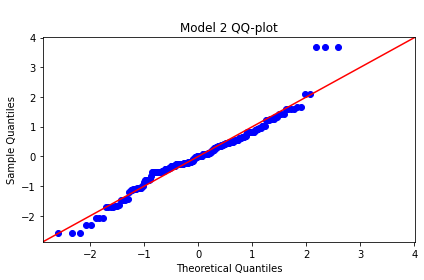

In [731]:
# plot the overall residuals via QQ-plot
qqplot(model_nbr=2, model=model_2)

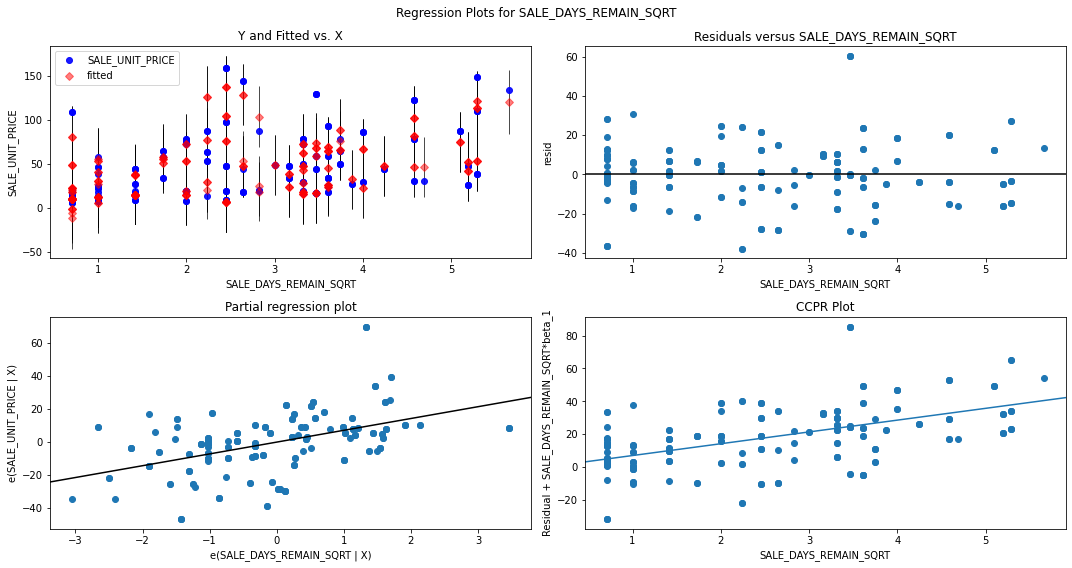

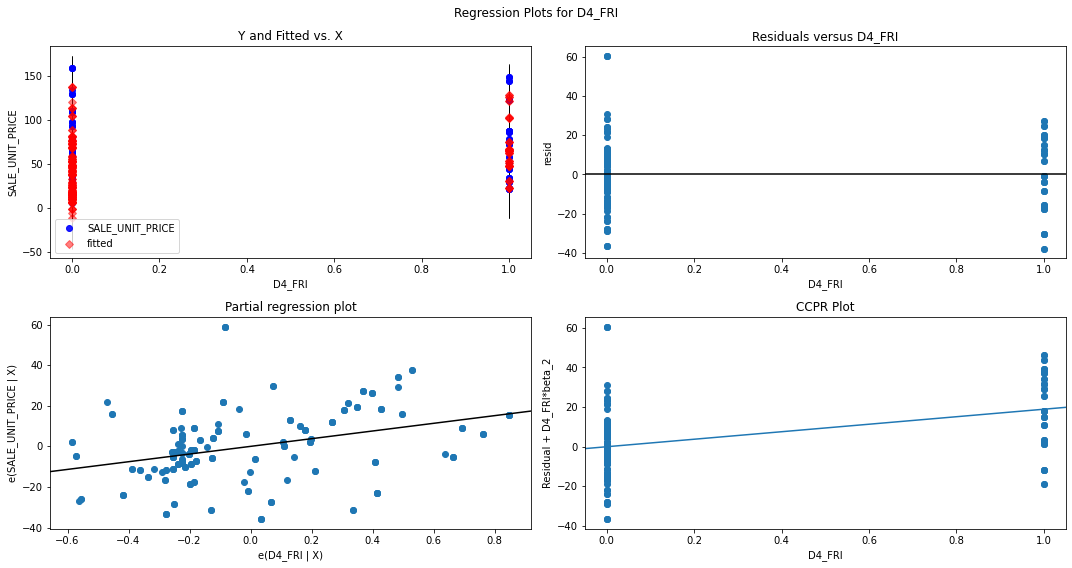

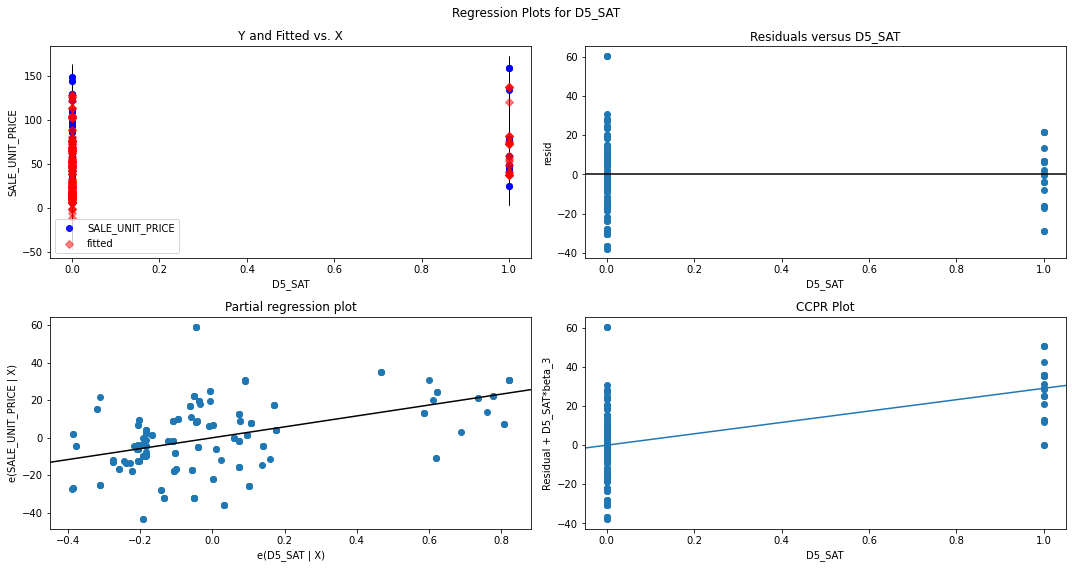

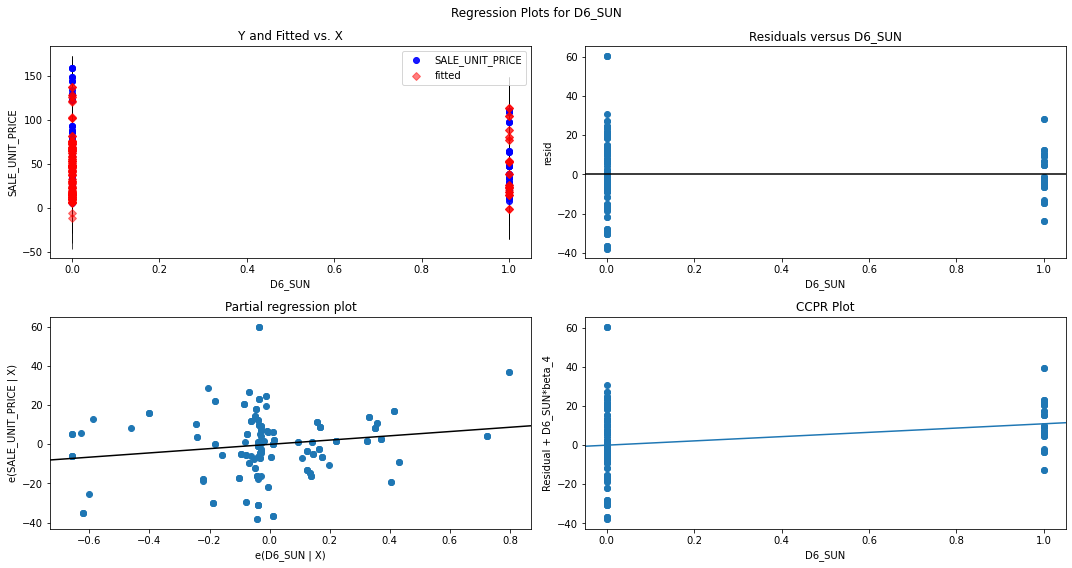

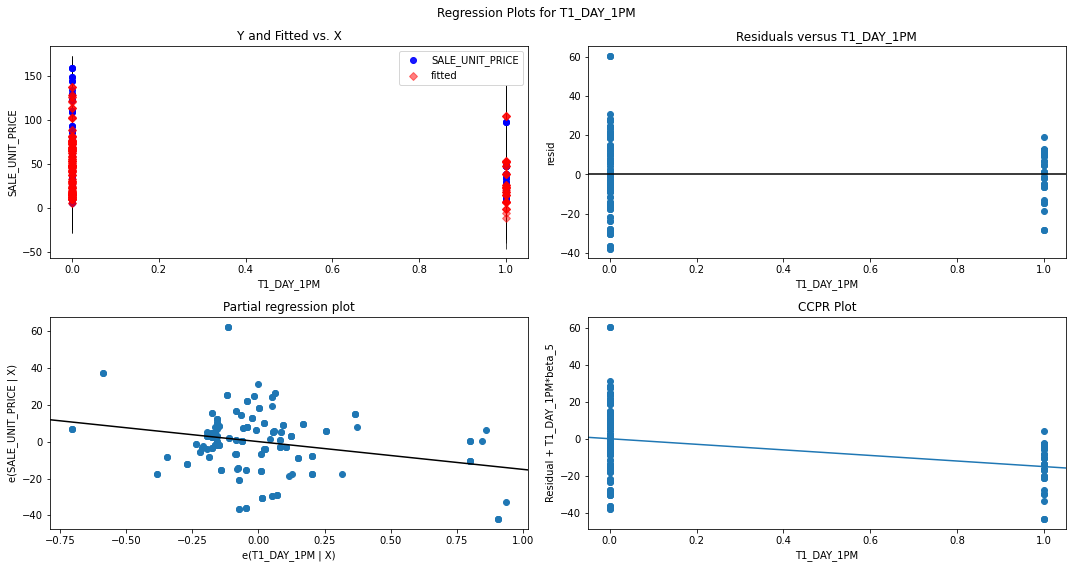

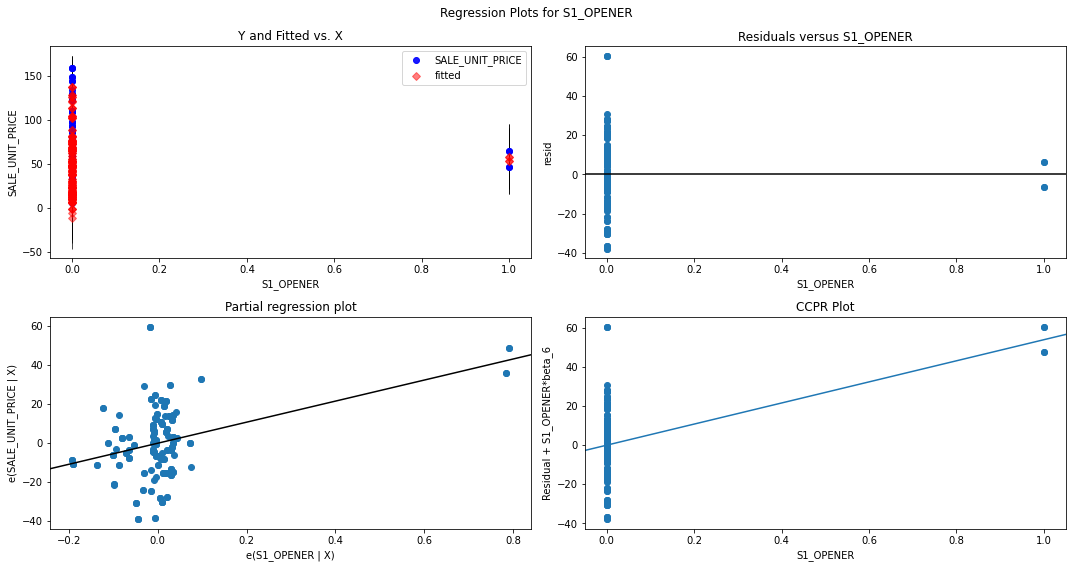

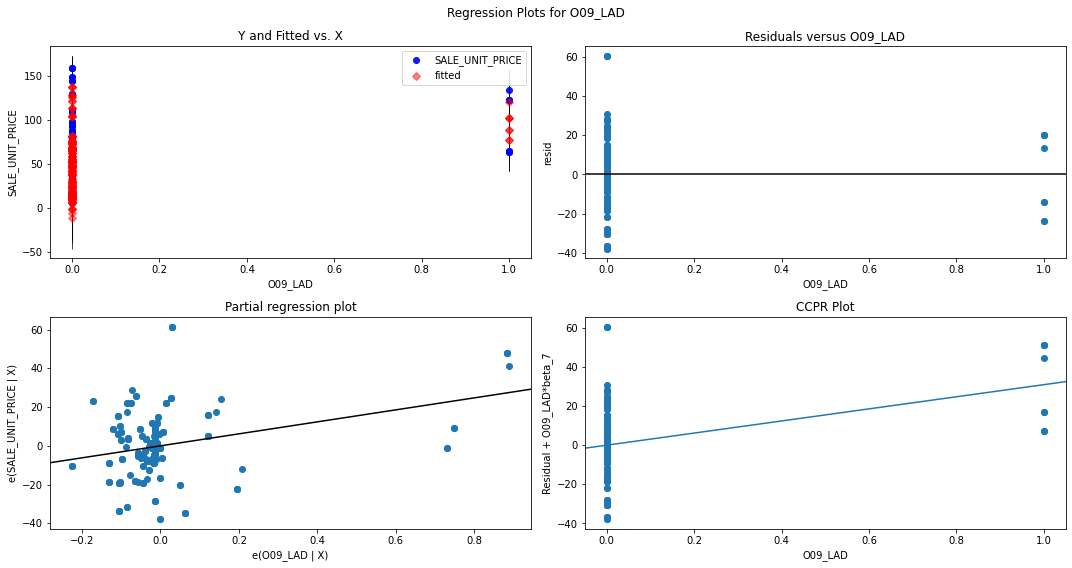

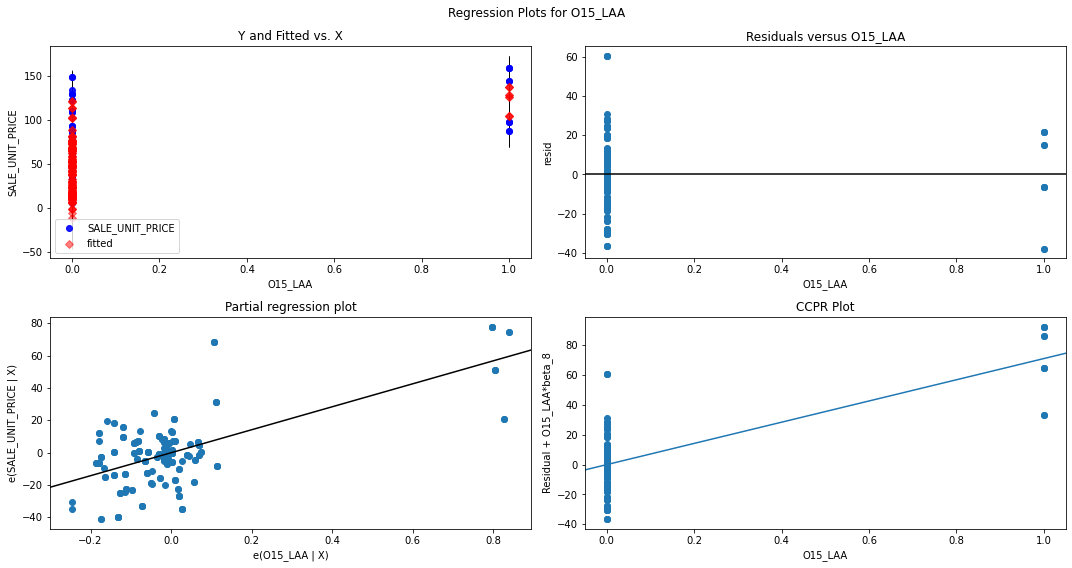

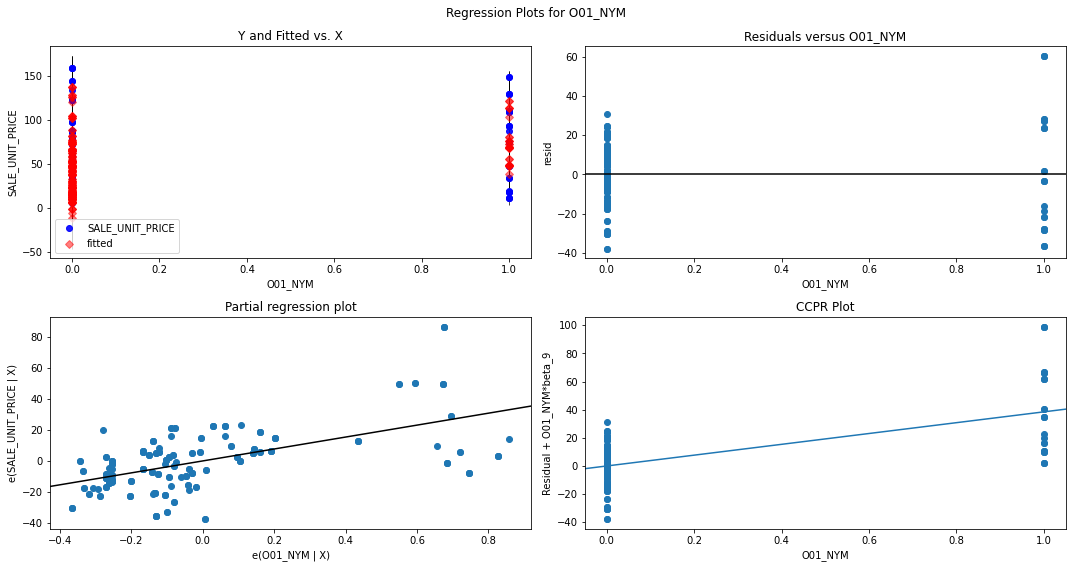

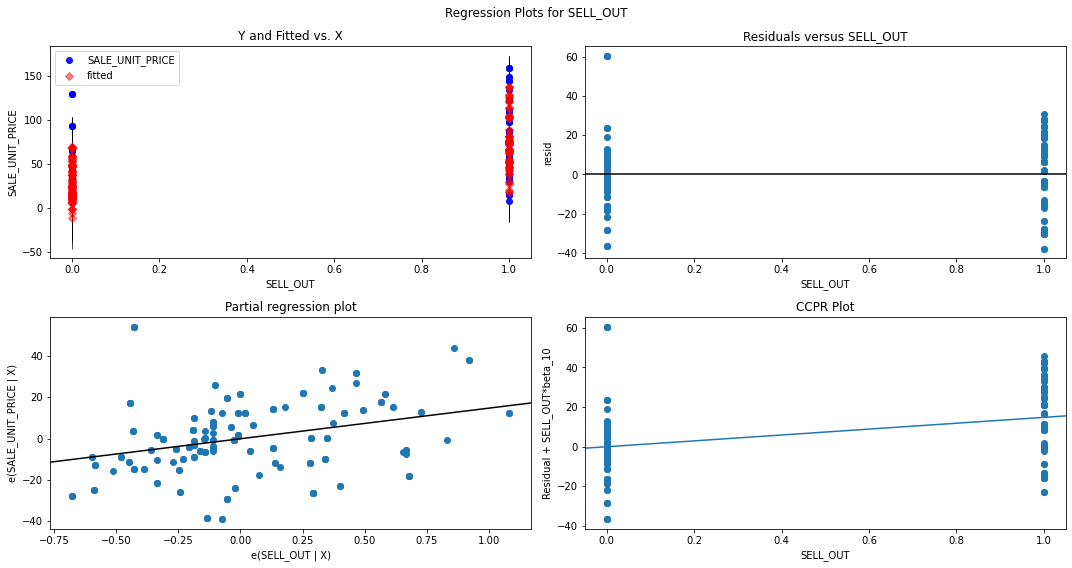

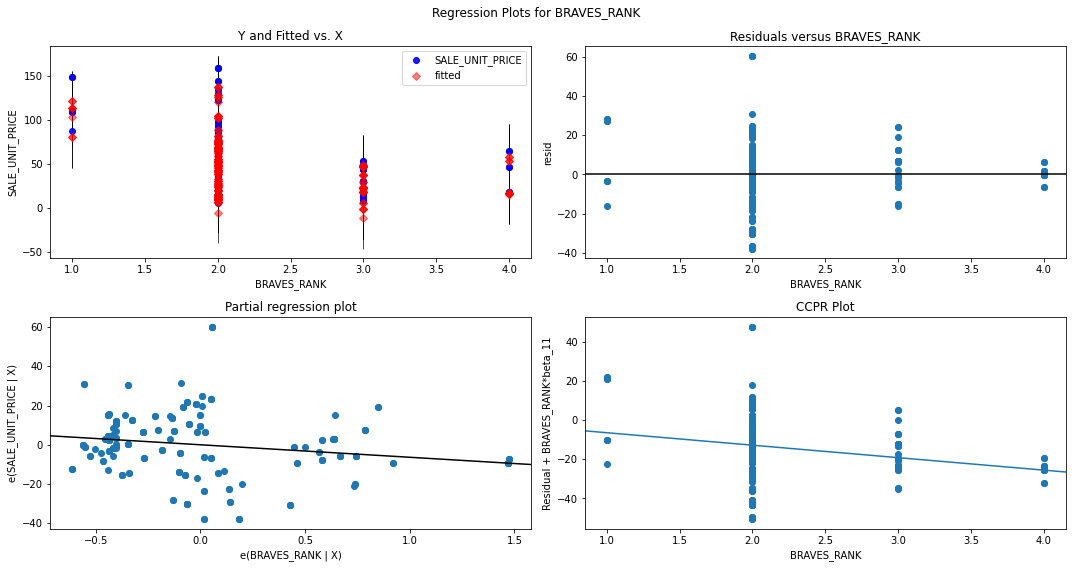

In [392]:
# plot feature residuals and check for homoskedacity
plot_residuals(model_nbr=2, model=model_2)

In [197]:
# cross validation to compare MAE on entire sample for m1 features
X_CV_m2 = X[features_m2]
y_CV_m2 = y['SALE_UNIT_PRICE']

kfolds(X_CV_m2, y_CV_m2, cv=5)

Cross-Validation MAE results: [10.03751067 11.93942516 24.6722929  19.24957687 14.5828084 ] | CV MAE Mean: 16.096322799942914


In [198]:
# call the preditions
y_pred_train_m2, y_pred_test_m2 = predict(2, model_2, X_train_m2, X_test_m2, y_train_m2, y_test_m2)


Model 2 Prediction Statistics
--------------------------
Root Mean Squared Error (RMSE): Test 17 | Train 16 |           Difference 1 | % Diff 0.0625
Mean Absolute Error (MAE): Test 11 | Train 12 |           Difference -1 | % Diff -0.08333333333333333


### Model 3 Sales Price SqRt

In [220]:
# model 3 setup and call statsmodel function
#features_m3 = ['SALE_DAYS_REMAIN','D1_TUE','D2_WED','T1_DAY_1PM','O01_NYM','O09_LAD','O15_LAA','SELL_OUT']
features_m3 = ['SALE_DAYS_REMAIN','D4_FRI','D5_SAT','D6_SUN','T1_DAY_1PM','S1_OPENER','SELL_OUT','O09_LAD','O15_LAA','O01_NYM']
# 'OPP_RANK', 'OPP_2022_ATTEND_AVG', 'OPP_MSA_POP', 'OPP_POP_PER_ATTEND '
# apply features to X_train and chose which y to predict
X_train_m3 = sm.add_constant(X_train[features_m3])
y_train_m3 = y_train['SALE_UNIT_PRICE_SQRT']

# apply features to X_test and chose which y to predict
X_test_m3 = sm.add_constant(X_test[features_m3])
y_test_m3 = y_test['SALE_UNIT_PRICE_SQRT']

# quick check of rows
X_train_m3.head()

,const,SALE_DAYS_REMAIN,D4_FRI,D5_SAT,D6_SUN,T1_DAY_1PM,S1_OPENER,SELL_OUT,O09_LAD,O15_LAA,O01_NYM
146,1.00,0,0,0,0,0,0,0,0,0,0
45,1.00,2,0,0,0,0,0,0,0,0,0
12,1.00,1,0,0,0,0,0,0,0,0,0
37,1.00,2,0,1,0,0,0,0,0,0,0
167,1.00,6,0,0,0,1,0,0,0,0,0


In [219]:
# run the model iteration and store in model variable
model_3, rsq_adj_m3, rmse_m3, mae_m3 = calc_sm_ols(model_nbr=3, X=X_train_m3, y=y_train_m3)

                             OLS Regression Results                             
Dep. Variable:     SALE_UNIT_PRICE_SQRT   R-squared:                       0.814
Model:                              OLS   Adj. R-squared:                  0.803
Method:                   Least Squares   F-statistic:                     77.90
Date:                  Sat, 13 May 2023   Prob (F-statistic):           2.20e-65
Time:                          09:58:25   Log-Likelihood:                -316.26
No. Observations:                   208   AIC:                             656.5
Df Residuals:                       196   BIC:                             696.6
Df Model:                            11                                         
Covariance Type:              nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               

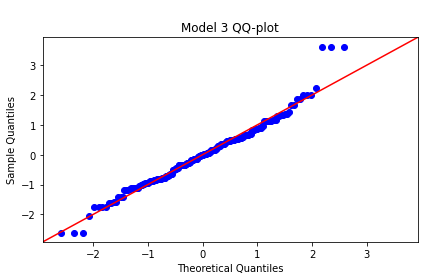

In [204]:
# plot the overall residuals via QQ-plot
qqplot(model_nbr=3, model=model_3)

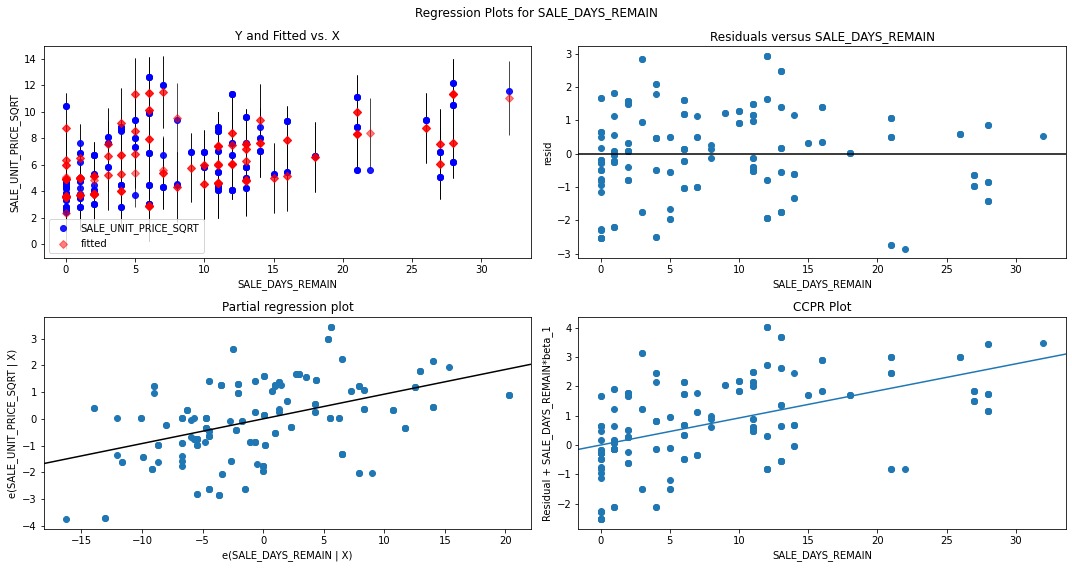

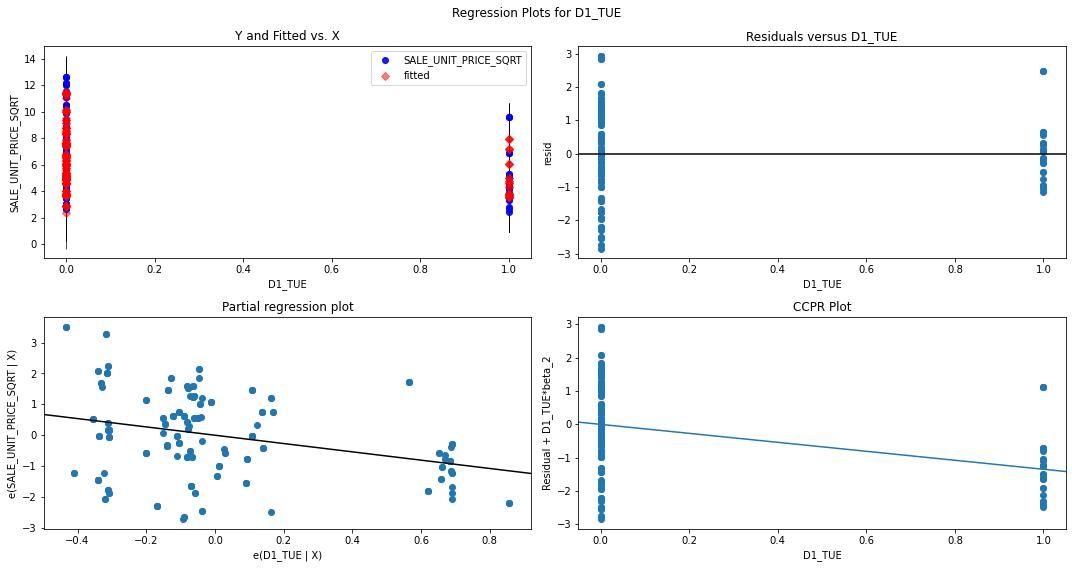

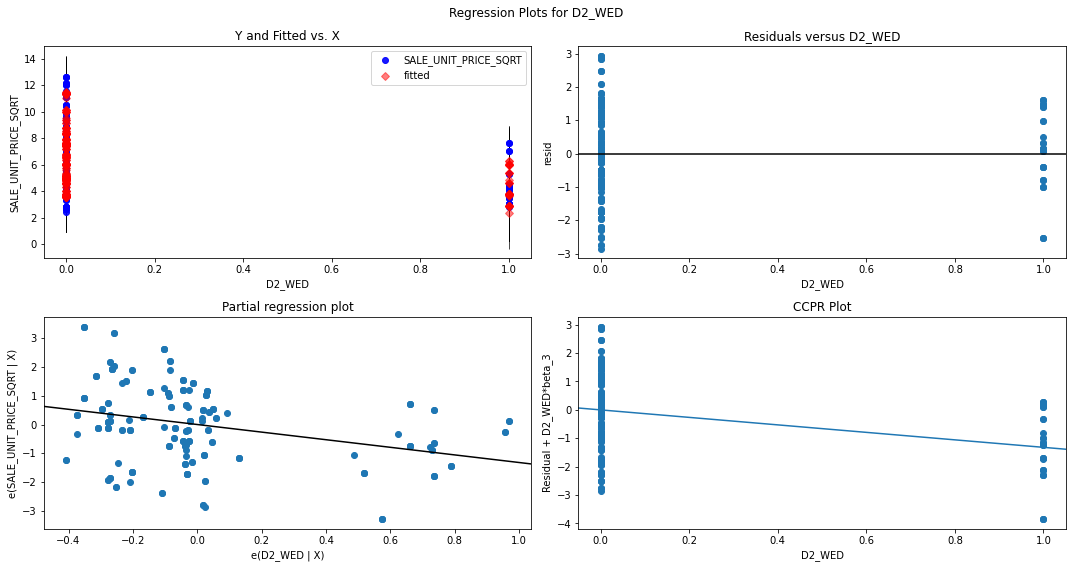

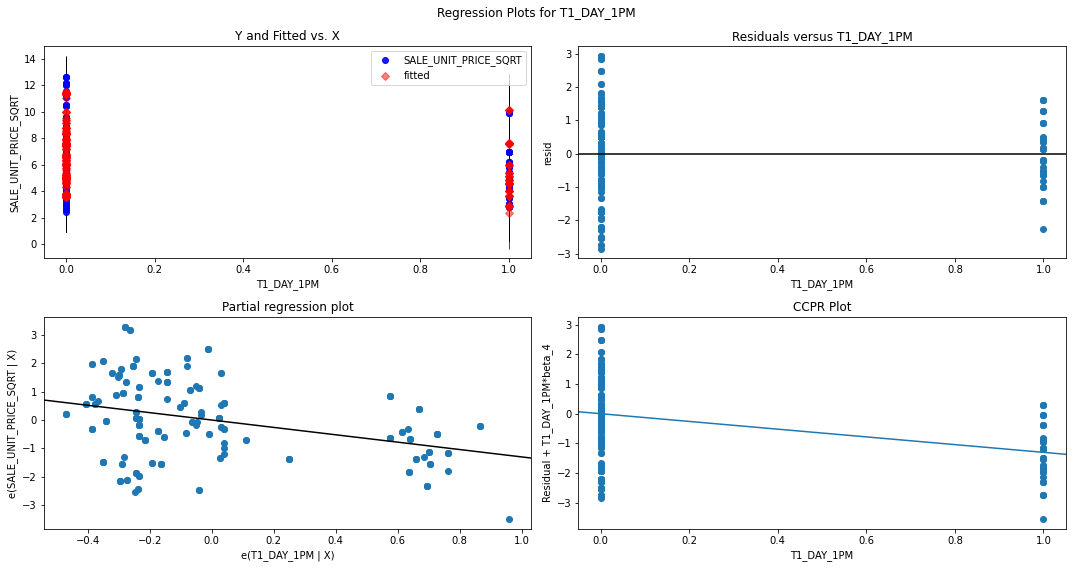

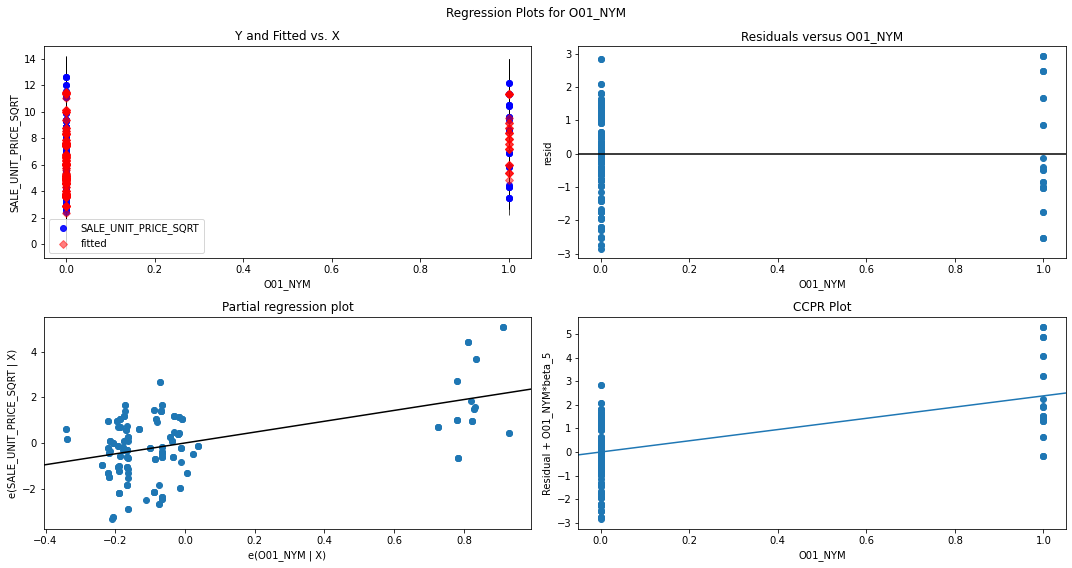

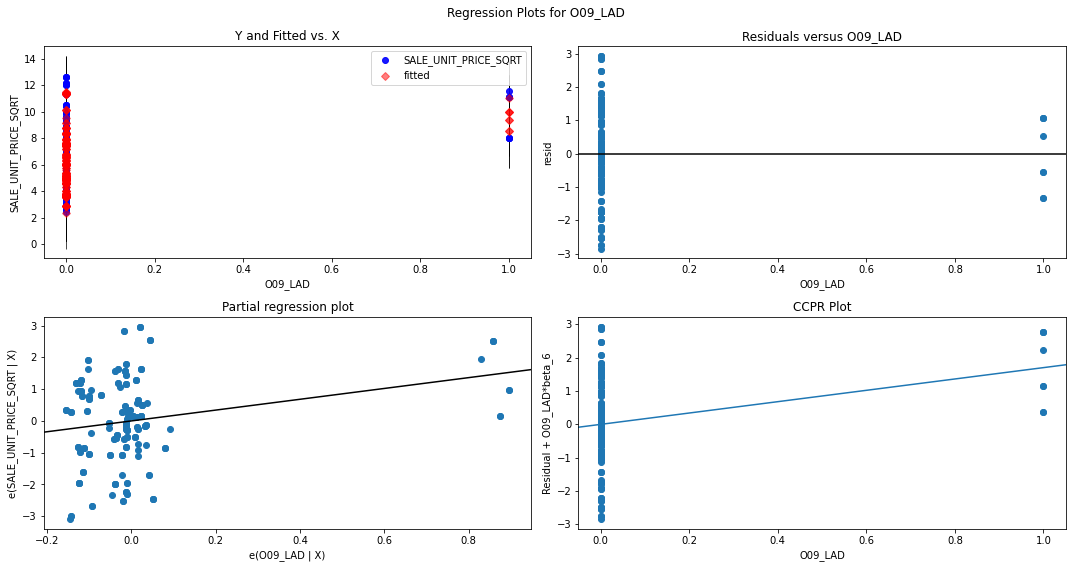

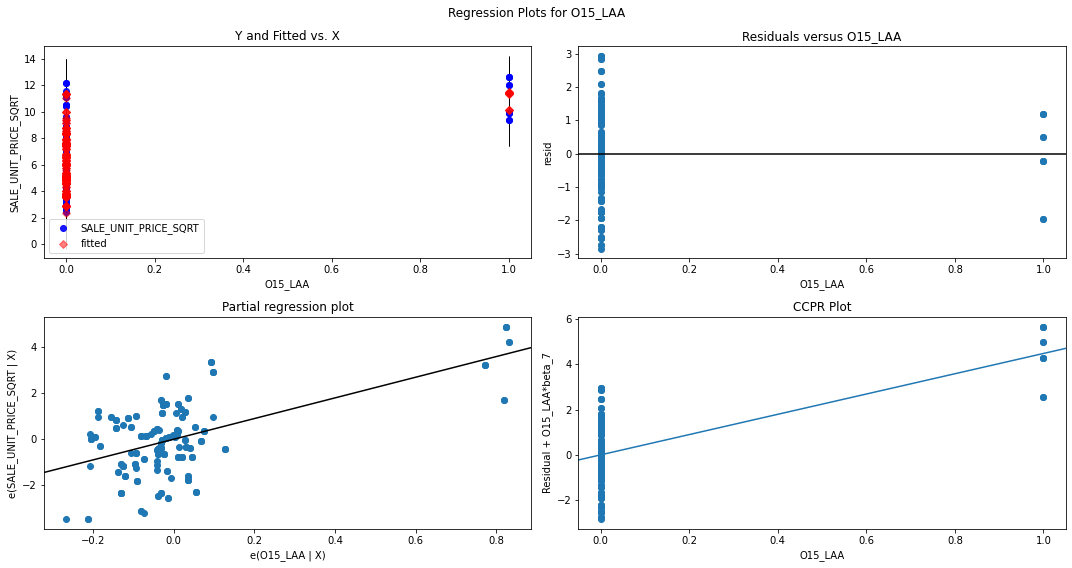

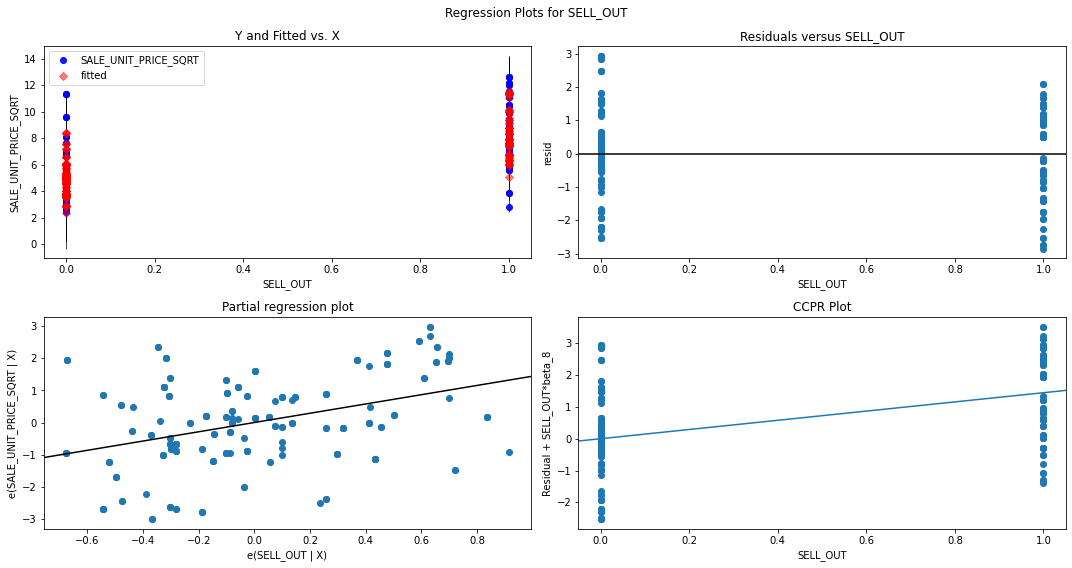

In [63]:
# plot feature residuals and check for homoskedacity
plot_residuals(model_nbr=3, model=model_3)

In [64]:
# cross validation to compare MAE on entire sample for m1 features
X_CV_m3 = X[features_m3]
y_CV_m3 = y['SALE_UNIT_PRICE_SQRT']

kfolds(X_CV_m3, y_CV_m3, cv=5)

Cross-Validation MAE results: [0.93243927 0.79376332 1.30699617 1.49406322 1.26961684] | CV MAE Mean: 1.1593757647904739


In [205]:
# call the preditions
y_pred_train_m3, y_pred_test_m3 = predict(3, model_3, X_train_m3, X_test_m3, y_train_m3, y_test_m3)


Model 3 Prediction Statistics
--------------------------
Root Mean Squared Error (RMSE): Test 16 | Train 16 |           Difference 0 | % Diff 0.0
Mean Absolute Error (MAE): Test 11 | Train 11 |           Difference 0 | % Diff 0.0


### Model 4 Sales Price Log

In [199]:
# model 4 setup and call statsmodel function
#features_m4 = ['SALE_DAYS_REMAIN','D1_TUE','D2_WED','T1_DAY_1PM','O01_NYM','O09_LAD','O15_LAA','SELL_OUT']
features_m4 = ['SALE_DAYS_REMAIN','D4_FRI','D5_SAT','D6_SUN','T1_DAY_1PM','BRAVES_RANK','S1_OPENER','SELL_OUT','O09_LAD','O15_LAA','O01_NYM']
# apply features to X_train and chose which y to predict
X_train_m4 = sm.add_constant(X_train[features_m4])
y_train_m4 = y_train['SALE_UNIT_PRICE_LOG']

# apply features to X_test and chose which y to predict
X_test_m4 = sm.add_constant(X_test[features_m4])
y_test_m4 = y_test['SALE_UNIT_PRICE_LOG']

# quick check of rows
X_train_m4.head()

,const,SALE_DAYS_REMAIN,D4_FRI,D5_SAT,D6_SUN,T1_DAY_1PM,BRAVES_RANK,S1_OPENER,SELL_OUT,O09_LAD,O15_LAA,O01_NYM
146,1.00,0,0,0,0,0,2,0,0,0,0,0
45,1.00,2,0,0,0,0,2,0,0,0,0,0
12,1.00,1,0,0,0,0,3,0,0,0,0,0
37,1.00,2,0,1,0,0,3,0,0,0,0,0
167,1.00,6,0,0,0,1,2,0,0,0,0,0


In [200]:
# run the model iteration and store in model variable
model_4, rsq_adj_m4, rmse_m4, mae_m4 = calc_sm_ols(model_nbr=4, X=X_train_m4, y=y_train_m4)

                             OLS Regression Results                            
Dep. Variable:     SALE_UNIT_PRICE_LOG   R-squared:                       0.789
Model:                             OLS   Adj. R-squared:                  0.777
Method:                  Least Squares   F-statistic:                     66.67
Date:                 Sat, 13 May 2023   Prob (F-statistic):           3.94e-60
Time:                         09:51:52   Log-Likelihood:                -93.865
No. Observations:                  208   AIC:                             211.7
Df Residuals:                      196   BIC:                             251.8
Df Model:                           11                                         
Covariance Type:             nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                2.6046   

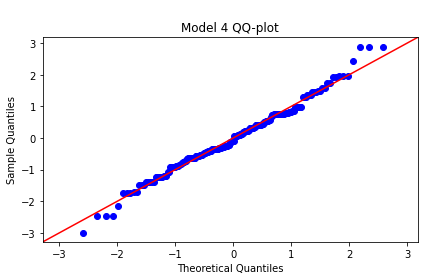

In [201]:
# plot the overall residuals via QQ-plot
qqplot(model_nbr=4, model=model_4)

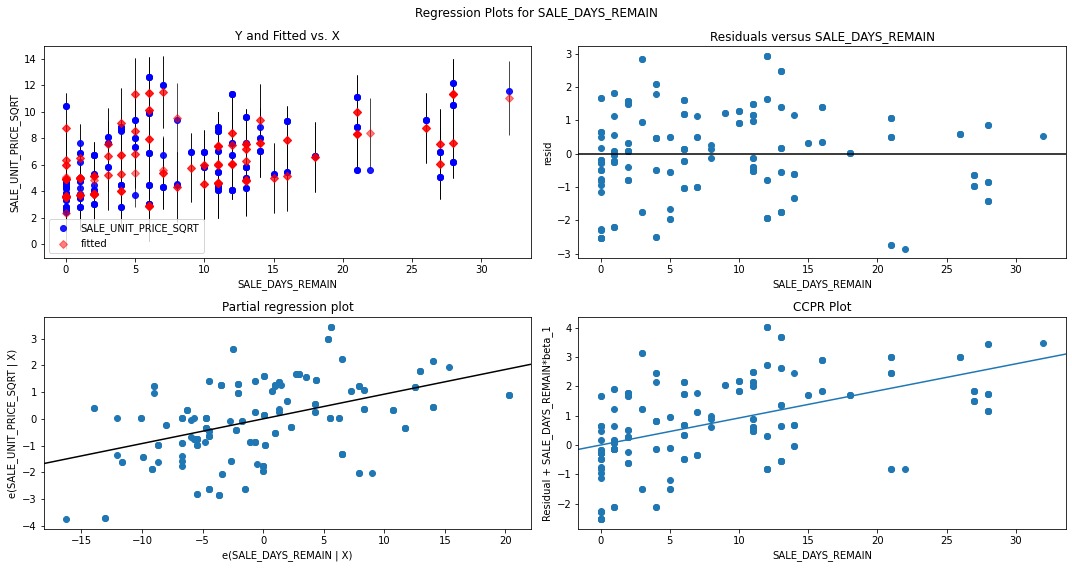

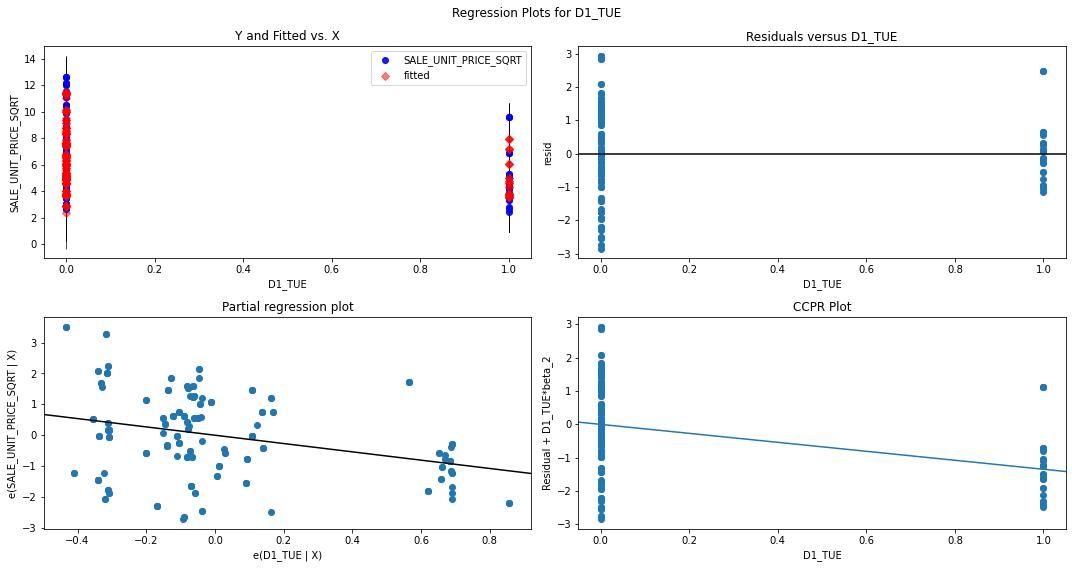

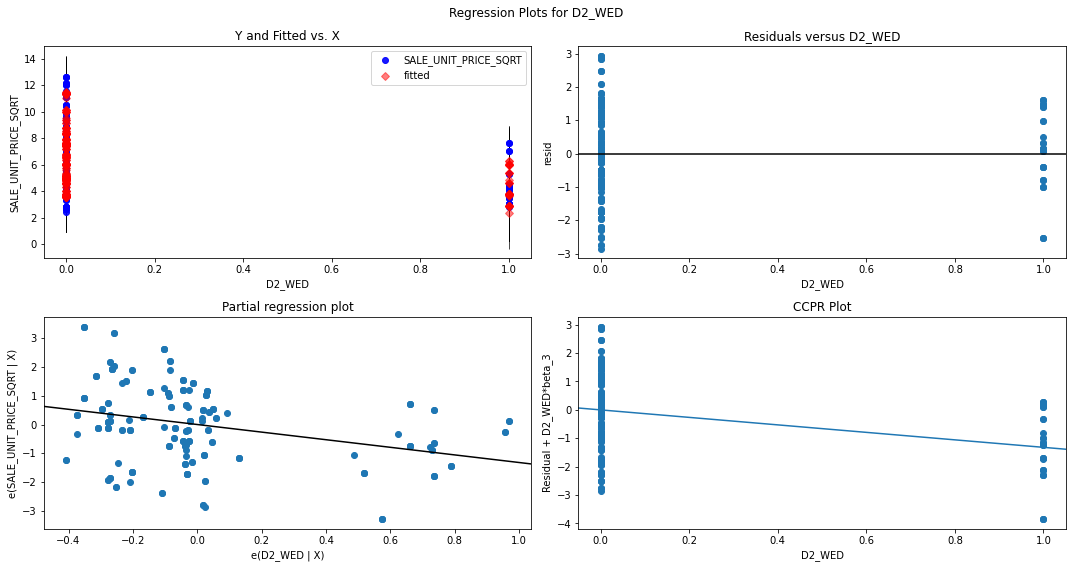

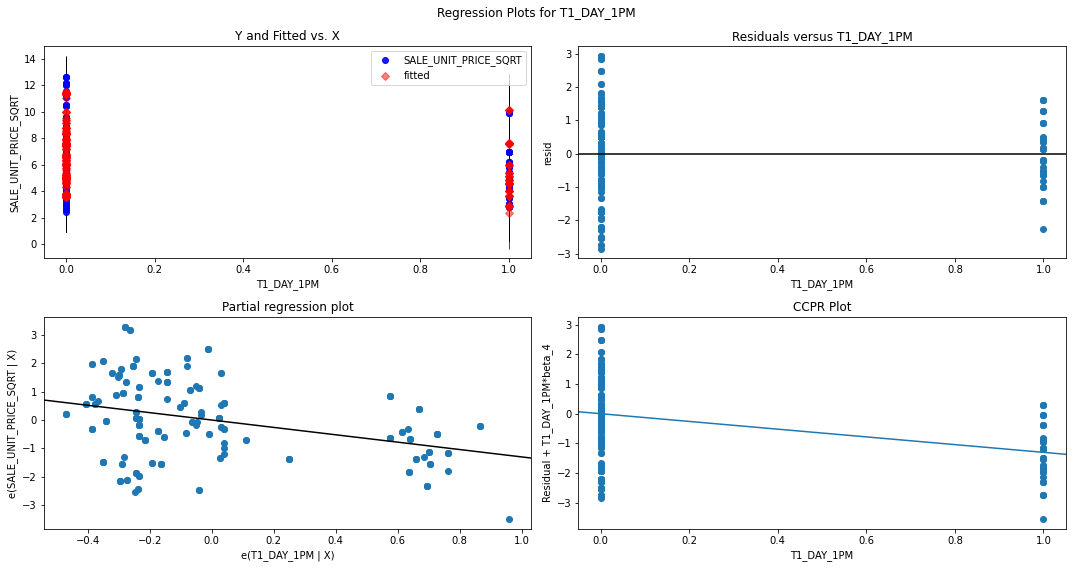

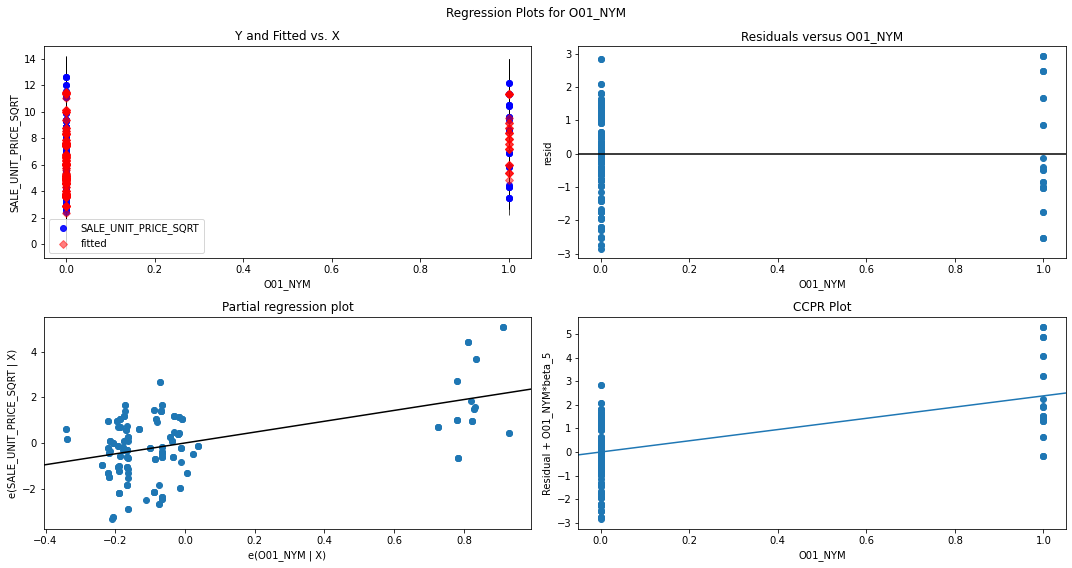

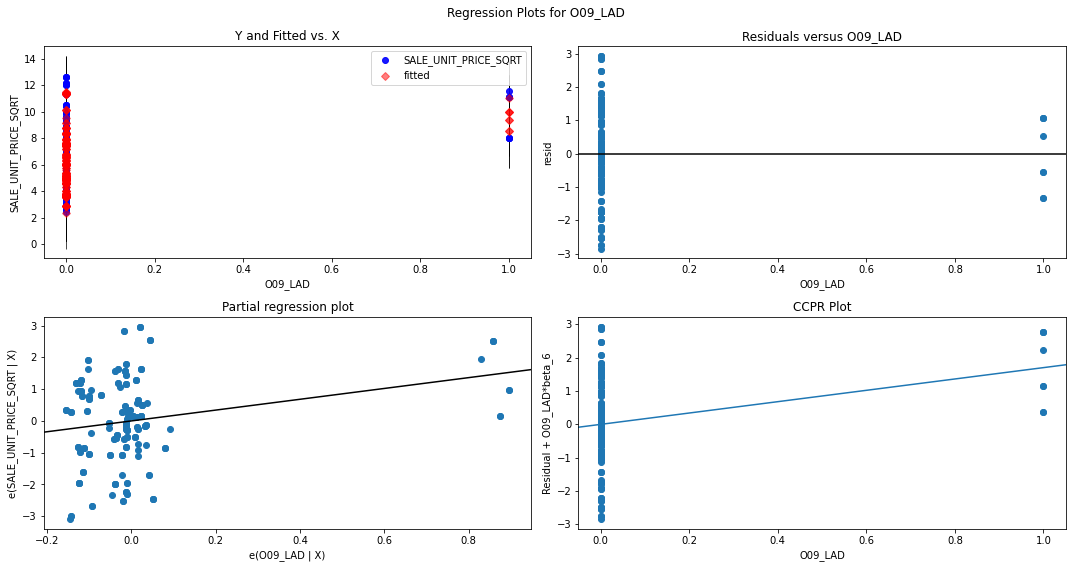

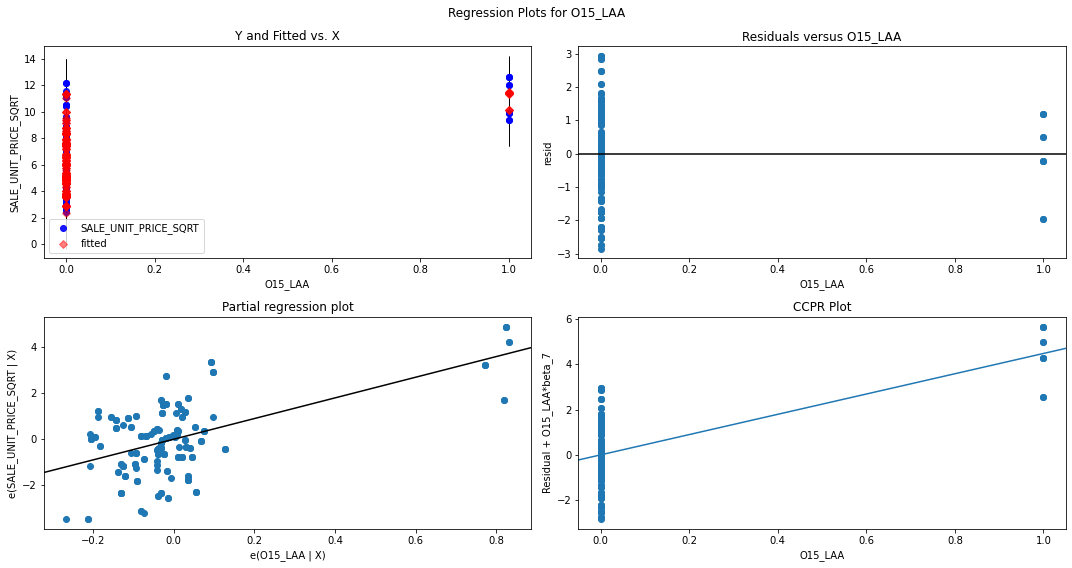

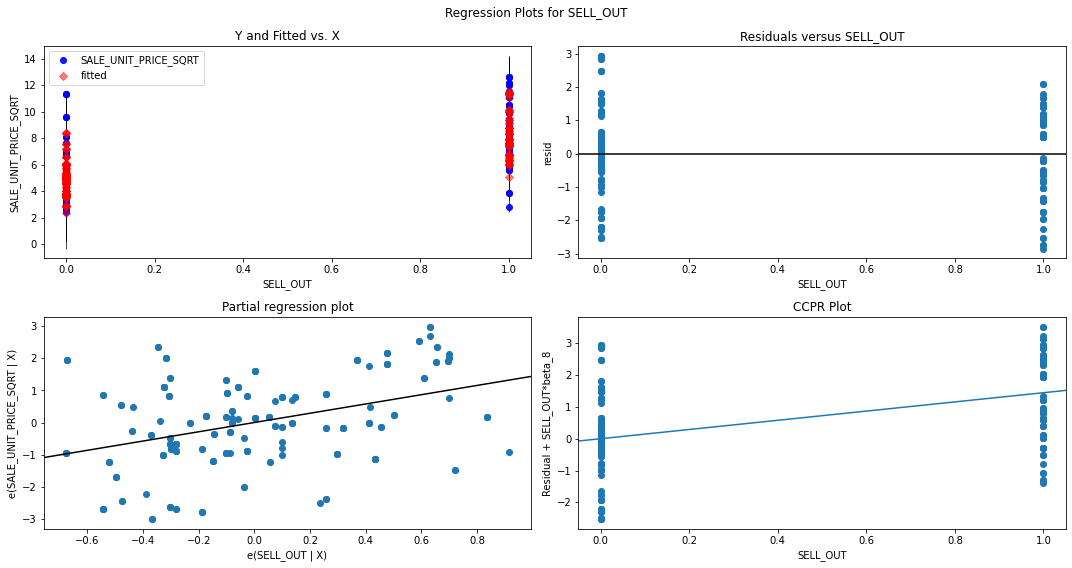

In [63]:
# plot feature residuals and check for homoskedacity
plot_residuals(model_nbr=3, model=model_3)

In [64]:
# cross validation to compare MAE on entire sample for m1 features
X_CV_m3 = X[features_m3]
y_CV_m3 = y['SALE_UNIT_PRICE_SQRT']

kfolds(X_CV_m3, y_CV_m3, cv=5)

Cross-Validation MAE results: [0.93243927 0.79376332 1.30699617 1.49406322 1.26961684] | CV MAE Mean: 1.1593757647904739


In [67]:
# call the preditions
y_pred_train_m3, y_pred_test_m3 = predict(3, model_3, X_train_m3, X_test_m3, y_train_m3, y_test_m3)


Model 3 Prediction Statistics
--------------------------
Root Mean Squared Error (RMSE): Test 18 | Train 18 |           Difference 0 | % Diff 0.0
Mean Absolute Error (MAE): Test 14 | Train 14 |           Difference 0 | % Diff 0.0


In [399]:
ridgeReg = Ridge(alpha=0.05, normalize=True)
ridgeReg.fit(X_train_m2, y_train_m2)
ridgeReg.predict(X_test_m2)
ridgeReg.score(X_train_m2, y_train_m2)
ridgeReg.score(X_test_m2, y_test_m2)

0.7966191286675959

## Parking Models

### Train-Test Split

In [192]:
# drop non-feature columns + drop multi-collinear columns 008_CIN, QTY_AVAIL, R1_BRAVES_GB, T1_DAY_1PM
parking.drop(columns=['MARGIN','NET_PAYOUT','SALE_EXT_AMT','STUBHUB_FEES','EXT_COST','MARGIN_PCT','WIN','LOSS','SAVE','TIME',
                    'CLI','DOW','RUNS','ORDER_NO','EXT_COST','INNINGS','RA','FULL_DATE','DAY_NIGHT','START_TIME','OUTCOME','POST_RECORD',
                    'GAME_DATE','DAY','START_TIME_ET','GAME','TYPE','LIST_DATE','SALE_DATE','BRAVES_CLASS','HOME_TEAM','AWAY_TEAM'], axis=1, inplace=True)

/Users/cutterback/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [195]:
# divide dataset into X predictors and y target
X2 = parking.drop(['SALE_UNIT_PRICE'], axis=1)
y2 = parking[['SALE_UNIT_PRICE']]

In [196]:
# split data 80% training and 20% test w/ random state for reproducability
X2_train, X2_test, y2_train, y2_test = train_test_split(
X2, y2, test_size=0.2, random_state=42)

In [197]:
# validate rows in splits look as expected
X2_train.shape, X2_test.shape, y2_train.shape, y2_test.shape

((51, 51), (13, 51), (51, 1), (13, 1))

In [198]:
# last check for any nans
X2_train[X2_train.isna().any(axis=1)]
X2_test[X2_test.isna().any(axis=1)]
y2_train[y2_train.isna().any(axis=1)]
y2_test[y2_test.isna().any(axis=1)]

,SALE_UNIT_PRICE


In [199]:
# full list of available columns to choose features for this model
print(X2_train.columns.tolist())

['LIST_DAYS_REMAIN', 'SALE_DAYS_REMAIN', 'QTY_AVAIL', 'QTY_SOLD', 'UNIT_COST', 'M2_MAY', 'M3_JUN', 'M4_JUL', 'M5_AUG', 'M6_SEP', 'M7_SCHOOL_OUT', 'D1_TUE', 'D2_WED', 'D3_THUR', 'D4_FRI', 'D5_SAT', 'D6_SUN', 'S1_OPENER', 'S2_MOTHERS_DAY', 'S3_INDEPENDENCE_DAY', 'T1_DAY_1PM', 'T1_DAY_4PM', 'O01_NYM', 'O02_PHL', 'O03_MIA', 'O04_STL', 'O05_MIL', 'O06_CHC', 'O07_PIT', 'O08_CIN', 'O09_LAD', 'O10_SDP', 'O11_SFG', 'O12_ARI', 'O13_COL', 'O14_HOU', 'O15_LAA', 'O16_OAK', 'O17_BOS', 'OC1_DIVISION', 'OC2_AL_INTER', 'BRAVES_RANK', 'R1_BRAVES_GB', 'ATTENDANCE', 'STREAK', 'SELL_OUT', 'QTY_SINGLE', 'QTY_FOUR', 'SOLD_SAME_DAY', 'SALE_DAYS_REMAIN_ADJ', 'SALE_UNIT_PRICE_SQRT']


### Model 5

In [202]:
# model 2 setup and call statsmodel function
features_m5 = ['SELL_OUT', 'SALE_DAYS_REMAIN']

# apply features to X_train and chose which y to predict
X_train_m5 = sm.add_constant(X2_train[features_m5])
y_train_m5 = y2_train['SALE_UNIT_PRICE']

# apply features to X_test and chose which y to predict
X_test_m5 = sm.add_constant(X2_test[features_m5])
y_test_m5 = y2_test['SALE_UNIT_PRICE']

# quick check of rows
X_train_m5.head()

,const,SELL_OUT,SALE_DAYS_REMAIN
36,1.00,0,0
92,1.00,1,4
139,1.00,1,5
8,1.00,1,12
46,1.00,0,0


In [203]:
# run the model iteration and store in model variable
model_5, rsq_adj_m5, rmse_m5, mae_m5 = calc_sm_ols(model_nbr=5, X=X_train_m5, y=y_train_m5)

                            OLS Regression Results                            
Dep. Variable:        SALE_UNIT_PRICE   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     21.39
Date:                Sat, 06 May 2023   Prob (F-statistic):           2.28e-07
Time:                        17:24:54   Log-Likelihood:                -199.91
No. Observations:                  51   AIC:                             405.8
Df Residuals:                      48   BIC:                             411.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               27.1711      2.505  

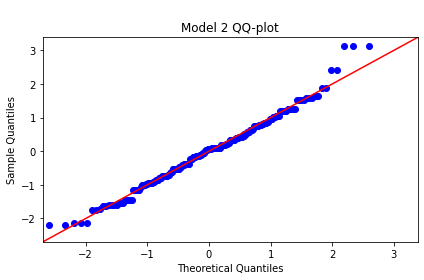

In [50]:
# plot the overall residuals via QQ-plot
qqplot(model_nbr=2, model=model_2)

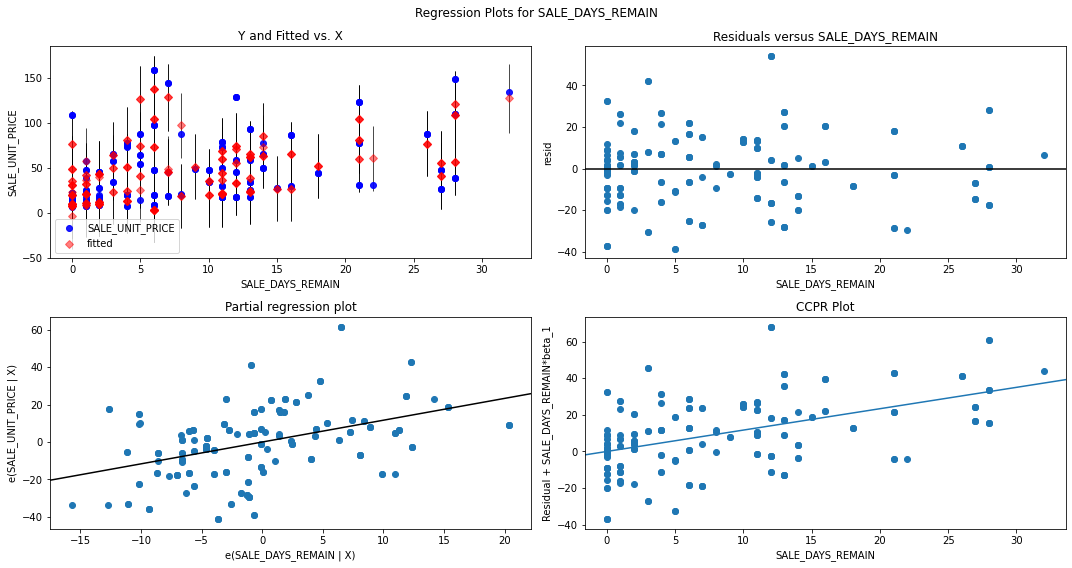

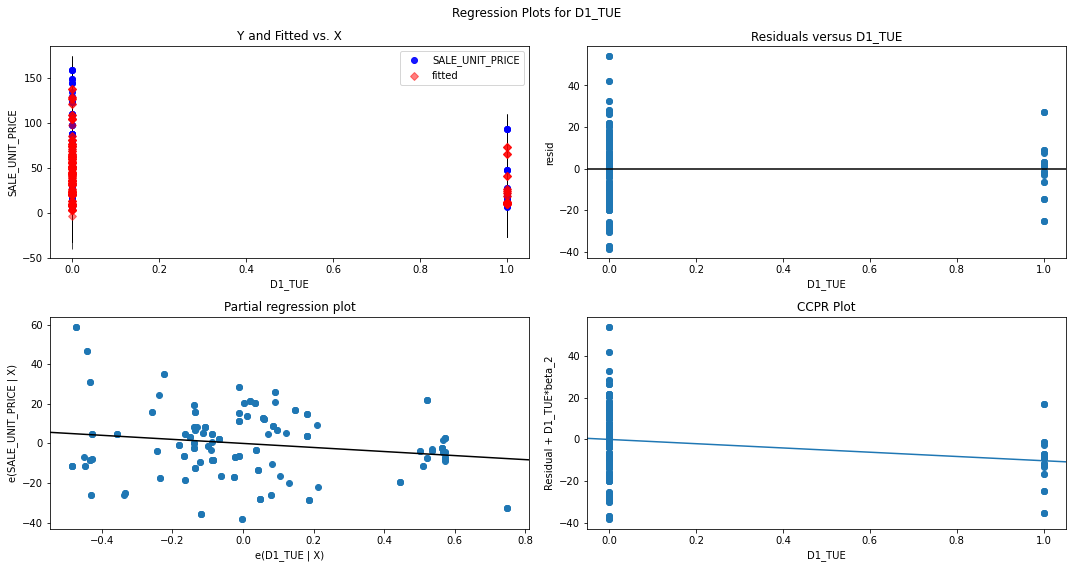

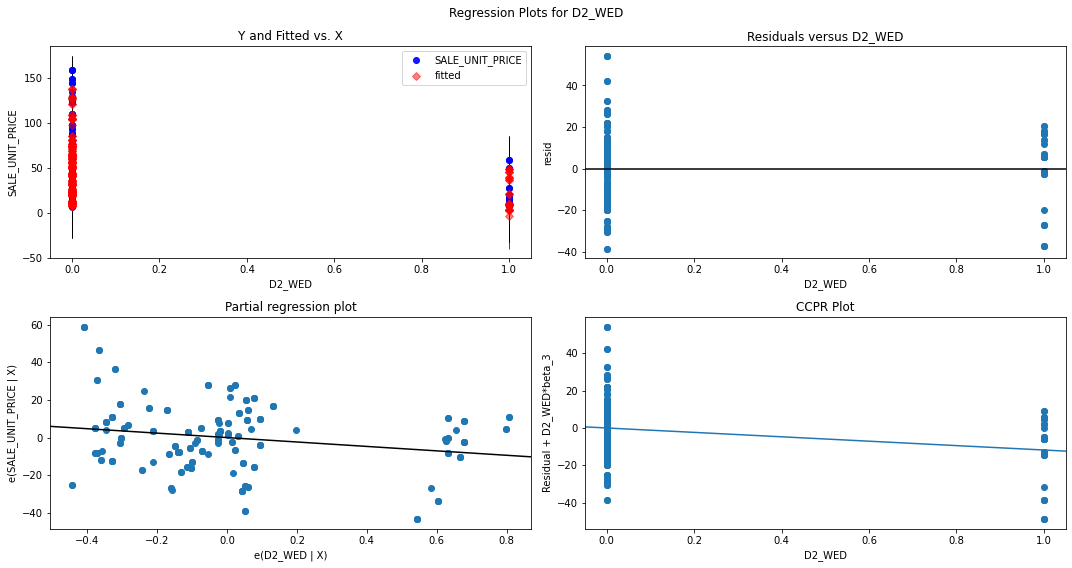

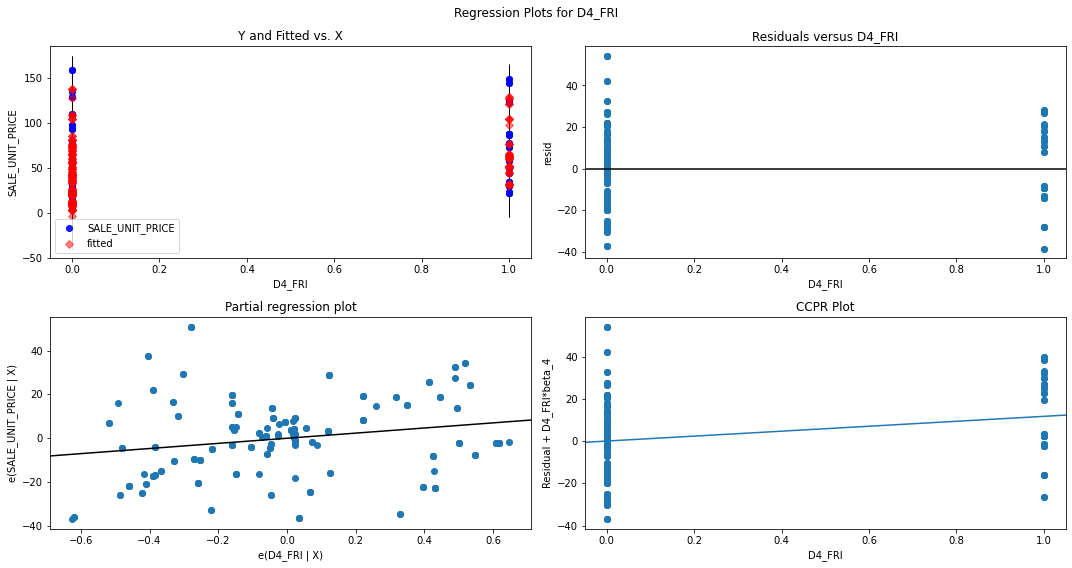

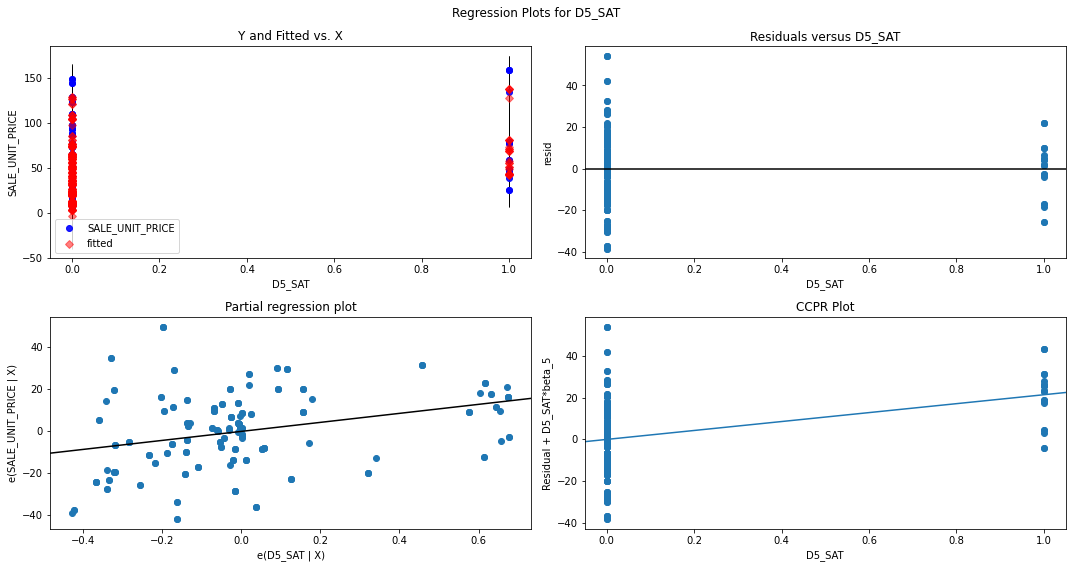

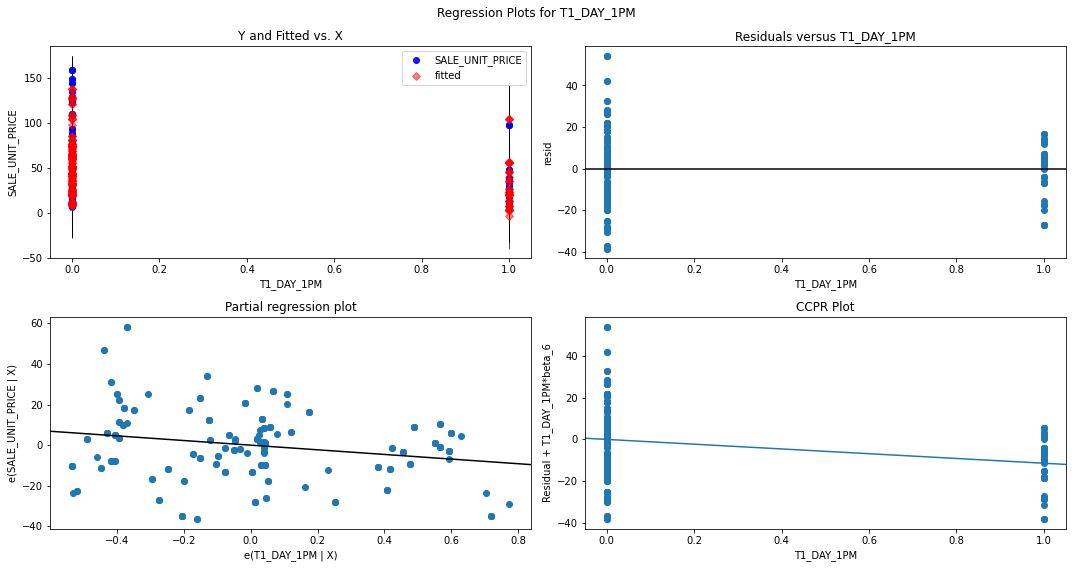

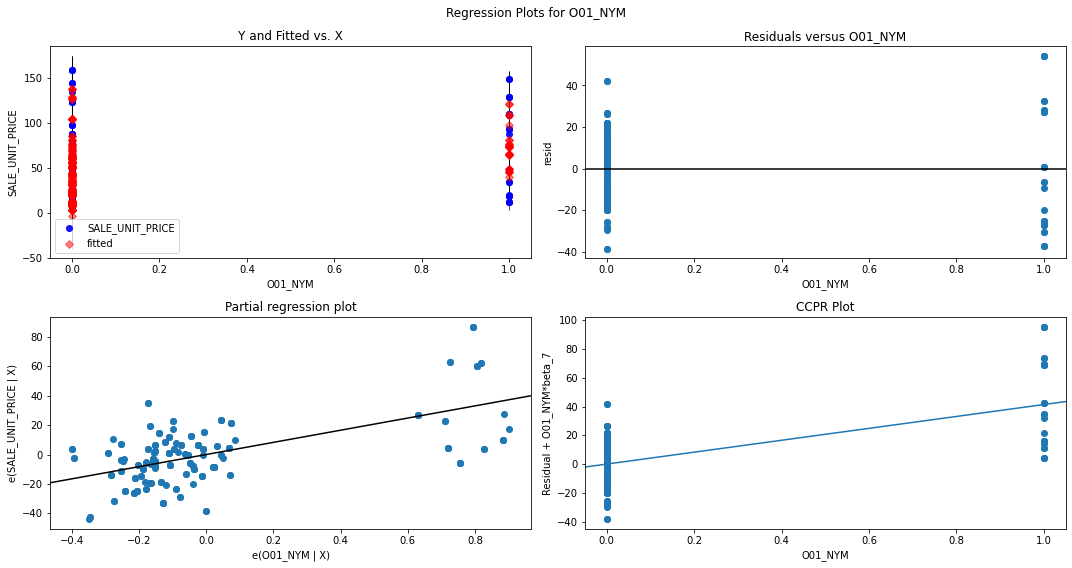

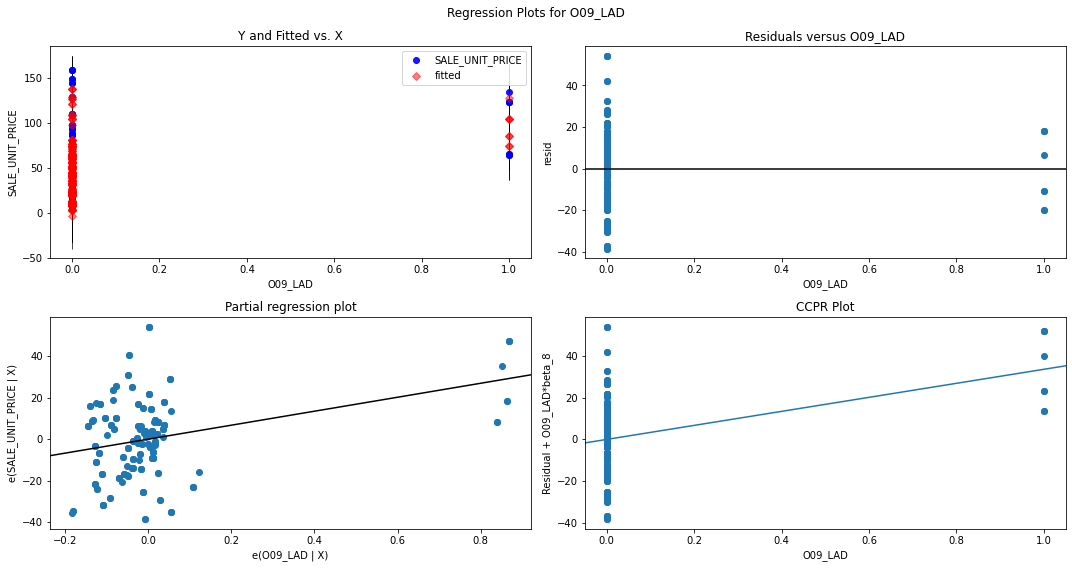

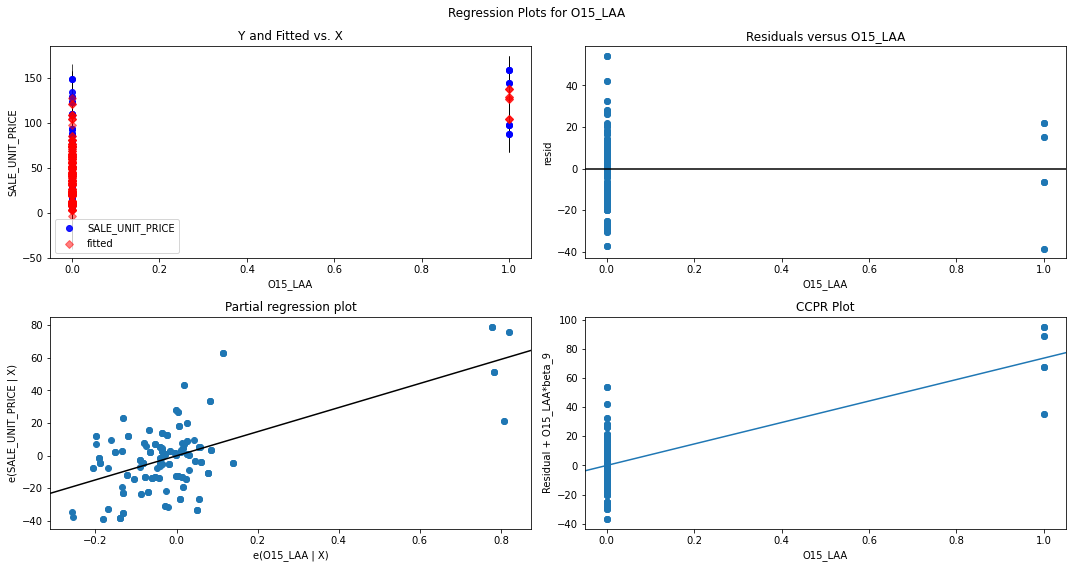

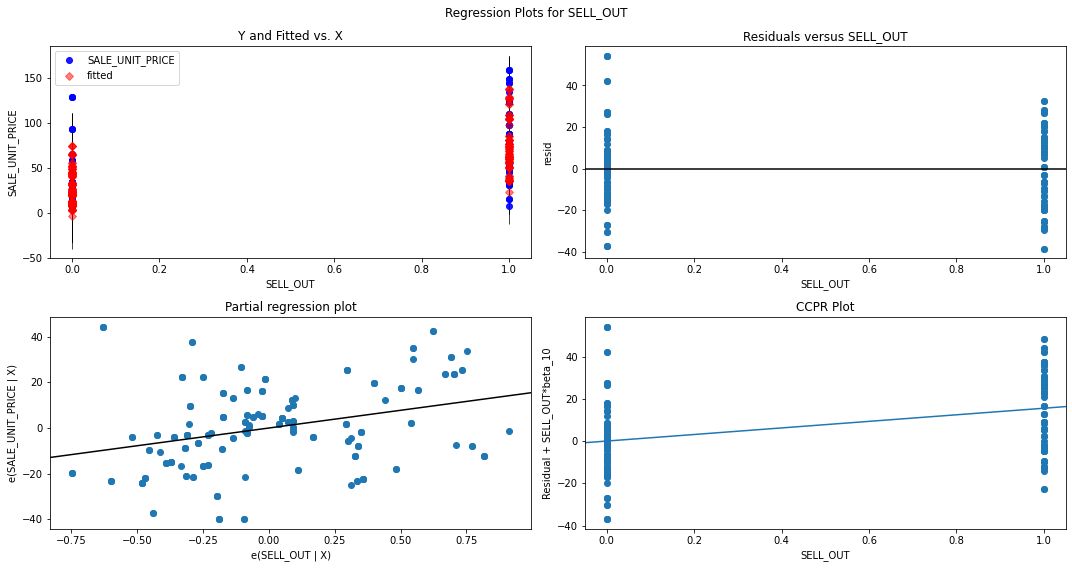

In [51]:
# plot feature residuals and check for homoskedacity
plot_residuals(model_nbr=2, model=model_2)

In [52]:
# cross validation to compare MAE on entire sample for m1 features
X_CV_m2 = X[features_m2]
y_CV_m2 = y['SALE_UNIT_PRICE']

kfolds(X_CV_m2, y_CV_m2, cv=5)

Cross-Validation MAE results: [12.80091393 11.82067245 25.26982845 19.89717882 16.2672167 ] | CV MAE Mean: 17.211162067826805


In [53]:
# call the preditions
y_pred_train_m2, y_pred_test_m2 = predict(2, model_2, X_train_m2, X_test_m2, y_train_m2, y_test_m2)


Model 2 Prediction Statistics
--------------------------
Root Mean Squared Error (RMSE): Test 17 | Train 17 |           Difference 0 | % Diff 0.0
Mean Absolute Error (MAE): Test 11 | Train 14 |           Difference -3 | % Diff -0.21428571428571427
